In [1]:
import pandas as pd 
import math, random
all_data  = pd.read_csv("sensor_data_200.txt", delimiter=" ", header=None, names = ("date","time","ir","z"))#lidarのセンサ値は「z」に
data = all_data.sample(3000).sort_values(by="z").reset_index()  #1000個だけサンプリングしてインデックスを振り直す
data = pd.DataFrame(data["z"])

In [2]:
##負担率の初期化## 

K = 3 #クラスタ数
n = int(math.ceil(len(data)/K)) #クラスタあたりのセンサ値の数
for k in range(K):
    data[k] = [1.0 if k == int(i/n) else 0.0 for i,d in data.iterrows()] #データをK個に分けて、一つのr_{i,k}を1に。他を0に。

In [3]:
def update_parameters(ds, k, mu_avg=200, zeta=1, alpha=1, beta=1, tau=1): 
    R = sum([d[k] for _, d in ds.iterrows()])
    S = sum([d[k]*d["z"] for _, d in ds.iterrows()])
    T = sum([d[k]*(d["z"]**2) for _, d in ds.iterrows()])
    
    hat = {}

    hat["tau"] = R + tau
    hat["zeta"] = R + zeta
    hat["mu_avg"] = (S + zeta*mu_avg)/hat["zeta"]
    hat["alpha"] = R/2 + alpha
    hat["beta"] = (T + zeta*(mu_avg**2) - hat["zeta"]*(hat["mu_avg"]**2))/2 + beta
    
    hat["z_std"] = math.sqrt(hat["beta"]/hat["alpha"])
    
    return pd.DataFrame(hat, index=[k])

In [16]:
from scipy.stats import norm, dirichlet
import matplotlib.pyplot as plt
import numpy as np

def draw(ps):
    pi = dirichlet([ps["tau"][k] for k in range(K)]).rvs()[0]
    pdfs = [ norm(loc=ps["mu_avg"][k], scale=ps["z_std"][k]) for k in range(K) ]

    xs = np.arange(190,230,0.5)

    ##p(z)の描画##
    ys = [ sum([pdfs[k].pdf(x)*pi[k] for k in range(K)])*len(data) for x in xs] #pdfを足してデータ数をかける
    plt.plot(xs, ys, color="red")

    ##各ガウス分布の描画##
    for k in range(K):
        ys = [pdfs[k].pdf(x)*pi[k]*len(data) for x in xs]
        plt.plot(xs, ys, color="blue")

    ##元のデータのヒストグラムの描画##
    data["z"].hist(bins = max(data["z"]) - min(data["z"]), align='left', alpha=0.4, color="gray")
    plt.show()

In [5]:
from scipy.special import digamma 

def responsibility(z, K, ps):
    tau_sum = sum([ps["tau"][k] for k in range(K)])
    r = {}
    for k in range(K):
        log_rho = (digamma(ps["alpha"][k]) - math.log(ps["beta"][k]))/2 \
                            - (1/ps["zeta"][k] + ((ps["mu_avg"][k] - z)**2)*ps["alpha"][k]/ps["beta"][k])/2 \
                            + digamma(ps["tau"][k]) - digamma(tau_sum)
                
        r[k] = math.exp(log_rho)
       
    w = sum([ r[k] for k in range(K) ]) #正規化
    for k in range(K): r[k] /= w
    
    return r

In [6]:
def one_step(ds): ###variationalinference2onestep
    ##パラメータの更新##
    params = pd.concat([update_parameters(ds, k) for k in range(K)]) 

    ##負担率の更新##
    rs = [responsibility(d["z"], K, params) for _, d in ds.iterrows() ]
    for k in range(K):
        ds[k] = [rs[i][k] for i,_ in data.iterrows()]
        
    return ds, params

In [7]:
params_history = {} ###variationalinference2iter
for t in range(1, 10000):
    data, params = one_step(data)
    if t%10 ==0:              #10回ごとにパラメータを記録
        params_history[t] = params
        display(params)
        
        if len(params_history) < 2:
            continue
           
        if all([ abs(params_history[t-10]["tau"][k] - params_history[t]["tau"][k]) < 10e-5 for k in range(K)]):
            break

,tau,zeta,mu_avg,alpha,beta,z_std
0,1014.461925,1014.461925,204.776089,507.730963,4010.162075,2.810374
1,868.359801,868.359801,209.451311,434.679900,2376.718035,2.338321
2,1120.178274,1120.178274,214.164443,560.589137,5393.561668,3.101812


,tau,zeta,mu_avg,alpha,beta,z_std
0,982.978341,982.978341,204.884171,491.989171,4254.275250,2.940594
1,851.324100,851.324100,209.362310,426.162050,3217.770963,2.747832
2,1168.697558,1168.697558,213.816753,584.848779,6445.689367,3.319807


,tau,zeta,mu_avg,alpha,beta,z_std
0,954.640912,954.640912,204.946561,477.820456,4317.628823,3.006009
1,844.419636,844.419636,209.295157,422.709818,3874.835892,3.027649
2,1203.939452,1203.939452,213.578588,602.469726,7165.829423,3.448781


,tau,zeta,mu_avg,alpha,beta,z_std
0,929.859788,929.859788,204.995244,465.429894,4317.603259,3.045750
1,839.944107,839.944107,209.240217,420.472053,4439.793002,3.249472
2,1233.196106,1233.196106,213.390293,617.098053,7734.062056,3.540191


,tau,zeta,mu_avg,alpha,beta,z_std
0,907.951443,907.951443,205.036871,454.475721,4283.306654,3.069971
1,836.080147,836.080147,209.193591,418.540074,4942.551279,3.436427
2,1258.968410,1258.968410,213.232410,629.984205,8209.019667,3.609781


,tau,zeta,mu_avg,alpha,beta,z_std
0,888.272943,888.272943,205.072864,444.636472,4225.498945,3.082737
1,832.221198,832.221198,209.152784,416.610599,5395.380161,3.598702
2,1282.505859,1282.505859,213.096058,641.752929,8618.012883,3.664541


,tau,zeta,mu_avg,alpha,beta,z_std
0,870.312744,870.312744,205.103261,435.656372,4149.733441,3.086299
1,828.133099,828.133099,209.115824,414.566549,5803.655455,3.741568
2,1304.554158,1304.554158,212.976427,652.777079,8976.608642,3.708290


,tau,zeta,mu_avg,alpha,beta,z_std
0,853.700676,853.700676,205.127821,427.350338,4060.088611,3.082306
1,823.719059,823.719059,209.081227,412.359529,6169.514934,3.868009
2,1325.580265,1325.580265,212.870587,663.290133,9295.032975,3.743464


,tau,zeta,mu_avg,alpha,beta,z_std
0,838.208763,838.208763,205.146335,419.604382,3960.466334,3.072226
1,818.935170,818.935170,209.048192,409.967585,6493.209194,3.979742
2,1345.856067,1345.856067,212.776563,673.428033,9580.780139,3.771854


,tau,zeta,mu_avg,alpha,beta,z_std
0,823.739761,823.739761,205.158695,412.369880,3855.036515,3.057530
1,813.756766,813.756766,209.016708,407.378383,6773.687260,4.077684
2,1365.503473,1365.503473,212.692879,683.251737,9839.836168,3.794928


,tau,zeta,mu_avg,alpha,beta,z_std
0,810.295240,810.295240,205.164930,405.64762,3748.211138,3.039748
1,808.169060,808.169060,208.987426,404.58453,7009.261502,4.162282
2,1384.535699,1384.535699,212.618325,692.76785,10077.284652,3.813976


,tau,zeta,mu_avg,alpha,beta,z_std
0,797.924525,797.924525,205.165294,399.462262,3644.245072,3.020410
1,802.171091,802.171091,208.961266,401.585546,7198.714110,4.233879
2,1402.904384,1402.904384,212.551830,701.952192,10297.543843,3.830126


,tau,zeta,mu_avg,alpha,beta,z_std
0,786.669968,786.669968,205.160371,393.834984,3546.639460,3.000899
1,795.782608,795.782608,208.938914,398.391304,7342.545140,4.293074
2,1420.547424,1420.547424,212.492408,710.773712,10504.342709,3.844313


,tau,zeta,mu_avg,alpha,beta,z_std
0,776.530189,776.530189,205.151087,388.765094,3457.667540,2.982277
1,789.044817,789.044817,208.920493,395.022408,7443.650622,4.340923
2,1437.424995,1437.424995,212.439158,719.212497,10700.582640,3.857226


,tau,zeta,mu_avg,alpha,beta,z_std
0,767.452207,767.452207,205.138581,384.226104,3378.274040,2.965200
1,782.012756,782.012756,208.905522,391.506378,7507.023113,4.378894
2,1453.535037,1453.535037,212.391276,727.267518,10888.269578,3.869299


,tau,zeta,mu_avg,alpha,beta,z_std
0,759.345576,759.345576,205.124016,380.172788,3308.336513,2.949948
1,774.744109,774.744109,208.893114,387.872054,7538.753615,4.408649
2,1468.910315,1468.910315,212.348074,734.955158,11068.616514,3.880755


,tau,zeta,mu_avg,alpha,beta,z_std
0,752.103269,752.103269,205.108411,376.551635,3247.083000,2.936530
1,767.290354,767.290354,208.882247,384.145177,7544.950797,4.431804
2,1483.606377,1483.606377,212.308982,742.303188,11242.274822,3.891674


,tau,zeta,mu_avg,alpha,beta,z_std
0,745.618304,745.618304,205.092557,373.309152,3193.467465,2.924805
1,759.692644,759.692644,208.871960,380.346322,7531.006060,4.449763
2,1497.689052,1497.689052,212.273531,749.344526,11409.585815,3.902062


,tau,zeta,mu_avg,alpha,beta,z_std
0,739.792878,739.792878,205.077008,370.396439,3146.416581,2.914571
1,751.981553,751.981553,208.861455,376.490777,7501.287114,4.463656
2,1511.225568,1511.225568,212.241333,756.112784,11570.772226,3.911901


,tau,zeta,mu_avg,alpha,beta,z_std
0,734.541573,734.541573,205.062115,367.770786,3104.953758,2.905621
1,744.178790,744.178790,208.850117,372.589395,7459.139340,4.474341
2,1524.279638,1524.279638,212.212062,762.639819,11726.047930,3.921174


,tau,zeta,mu_avg,alpha,beta,z_std
0,729.791204,729.791204,205.048080,365.395602,3068.241320,2.897765
1,736.299412,736.299412,208.837496,368.649706,7407.039859,4.482449
2,1536.909384,1536.909384,212.185437,768.954692,11875.662180,3.929873


,tau,zeta,mu_avg,alpha,beta,z_std
0,725.479317,725.479317,205.034998,363.239658,3035.579819,2.890841
1,728.353809,728.353809,208.823270,364.676905,7346.793850,4.488434
2,1549.166874,1549.166874,212.161215,775.083437,12019.904655,3.938005


,tau,zeta,mu_avg,alpha,beta,z_std
0,721.552387,721.552387,205.022893,361.276193,3006.390108,2.884716
1,720.349220,720.349220,208.807210,360.674610,7279.715731,4.492617
2,1561.098393,1561.098393,212.139179,781.049197,12159.092955,3.945585


,tau,zeta,mu_avg,alpha,beta,z_std
0,717.964211,717.964211,205.011750,359.482106,2980.191582,2.879277
1,712.290800,712.290800,208.789153,356.645400,7206.774465,4.495232
2,1572.744989,1572.744989,212.119136,786.872495,12293.555515,3.952634


,tau,zeta,mu_avg,alpha,beta,z_std
0,714.674605,714.674605,205.001528,357.837303,2956.582397,2.874433
1,704.182341,704.182341,208.768980,352.591171,7128.701157,4.496447
2,1584.143054,1584.143054,212.100911,792.571527,12423.616378,3.959176


,tau,zeta,mu_avg,alpha,beta,z_std
0,711.648395,711.648395,204.992178,356.324198,2935.223348,2.870106
1,696.026745,696.026745,208.746604,348.513373,7046.064853,4.496386
2,1595.324859,1595.324859,212.084344,798.162430,12549.584009,3.965236


,tau,zeta,mu_avg,alpha,beta,z_std
0,708.854646,708.854646,204.983642,354.927323,2915.825440,2.866230
1,687.826329,687.826329,208.721955,344.413164,6959.324061,4.495145
2,1606.319026,1606.319026,212.069291,803.659513,12671.744343,3.970838


,tau,zeta,mu_avg,alpha,beta,z_std
0,706.266057,706.266057,204.975865,353.633028,2898.140494,2.862749
1,679.583028,679.583028,208.694980,340.291514,6868.860886,4.492797
2,1617.150916,1617.150916,212.055619,809.075458,12790.357429,3.976004


,tau,zeta,mu_avg,alpha,beta,z_std
0,703.858473,703.858473,204.968795,352.429237,2881.954020,2.859615
1,671.298541,671.298541,208.665635,336.149270,6775.003127,4.489404
2,1627.842986,1627.842986,212.043203,814.421493,12905.656767,3.980755


,tau,zeta,mu_avg,alpha,beta,z_std
0,701.610476,701.610476,204.962383,351.305238,2867.079774,2.856785
1,662.974427,662.974427,208.633884,331.987213,6678.038285,4.485014
2,1638.415097,1638.415097,212.031930,819.707548,13017.850488,3.985109


,tau,zeta,mu_avg,alpha,beta,z_std
0,699.503022,699.503022,204.956583,350.251511,2853.355510,2.854223
1,654.612182,654.612182,208.599695,327.806091,6578.222182,4.479667
2,1648.884797,1648.884797,212.021695,824.942398,13127.123792,3.989082


,tau,zeta,mu_avg,alpha,beta,z_std
0,697.519112,697.519112,204.951356,349.259556,2840.639504,2.851897
1,646.213302,646.213302,208.563043,323.606651,6475.784192,4.473397
2,1659.267586,1659.267586,212.012398,830.133793,13233.641961,3.992690


,tau,zeta,mu_avg,alpha,beta,z_std
0,695.643489,695.643489,204.946665,348.321745,2828.807662,2.849781
1,637.779337,637.779337,208.523902,319.389668,6370.930272,4.466229
2,1669.577174,1669.577174,212.003947,835.288587,13337.553699,3.995948


,tau,zeta,mu_avg,alpha,beta,z_std
0,693.862349,693.862349,204.942478,347.431174,2817.751053,2.847849
1,629.311935,629.311935,208.482248,315.155967,6263.844771,4.458181
2,1679.825717,1679.825717,211.996257,840.412858,13438.994381,3.998868


,tau,zeta,mu_avg,alpha,beta,z_std
0,692.163063,692.163063,204.938765,346.581531,2807.373714,2.846082
1,620.812885,620.812885,208.438057,310.906443,6154.691488,4.449265
2,1690.024052,1690.024052,211.989246,845.512026,13538.089108,4.001463


,tau,zeta,mu_avg,alpha,beta,z_std
0,690.533920,690.533920,204.935501,345.766960,2797.590657,2.844463
1,612.284159,612.284159,208.391301,306.642079,6043.614500,4.439484
2,1700.181921,1700.181921,211.982840,850.590961,13634.955391,4.003746


,tau,zeta,mu_avg,alpha,beta,z_std
0,688.963873,688.963873,204.932661,344.981937,2788.326087,2.842979
1,603.727943,603.727943,208.341950,302.363972,5930.738894,4.428834
2,1710.308183,1710.308183,211.976968,855.654092,13729.705483,4.005728


,tau,zeta,mu_avg,alpha,beta,z_std
0,687.442303,687.442303,204.930226,344.221151,2779.511759,2.841617
1,595.146684,595.146684,208.289966,298.073342,5816.171572,4.417301
2,1720.411013,1720.411013,211.971563,860.705506,13822.448306,4.007423


,tau,zeta,mu_avg,alpha,beta,z_std
0,685.958787,685.958787,204.928176,343.479393,2771.085443,2.840368
1,586.543121,586.543121,208.235305,293.771560,5700.002245,4.404865
2,1730.498092,1730.498092,211.966562,865.749046,13913.291071,4.008842


,tau,zeta,mu_avg,alpha,beta,z_std
0,684.502884,684.502884,204.926495,342.751442,2762.989578,2.839226
1,577.920326,577.920326,208.177912,289.460163,5582.304517,4.391495
2,1740.576789,1740.576789,211.961907,870.788395,14002.340644,4.009997


,tau,zeta,mu_avg,alpha,beta,z_std
0,683.063923,683.063923,204.925168,342.031961,2755.170010,2.838186
1,569.281755,569.281755,208.117724,285.140877,5463.137205,4.377149
2,1750.654322,1750.654322,211.957542,875.827161,14089.704763,4.010899


,tau,zeta,mu_avg,alpha,beta,z_std
0,681.630795,681.630795,204.924183,341.315397,2747.574834,2.837245
1,560.631289,560.631289,208.054661,280.815645,5342.545820,4.361777
2,1760.737916,1760.737916,211.953414,880.868958,14175.493218,4.011561


,tau,zeta,mu_avg,alpha,beta,z_std
0,680.191754,680.191754,204.923530,340.595877,2740.153427,2.836402
1,551.973302,551.973302,207.988633,276.486651,5220.564256,4.345319
2,1770.834944,1770.834944,211.949472,885.917472,14259.819112,4.011995


,tau,zeta,mu_avg,alpha,beta,z_std
0,678.734217,678.734217,204.923202,339.867108,2732.855527,2.835657
1,543.312720,543.312720,207.919536,272.156360,5097.216719,4.327702
2,1780.953063,1780.953063,211.945666,890.976531,14342.800313,4.012212


,tau,zeta,mu_avg,alpha,beta,z_std
0,677.244569,677.244569,204.923193,339.122285,2725.630460,2.835015
1,534.655109,534.655109,207.847247,267.827554,4972.520069,4.308843
2,1791.100322,1791.100322,211.941946,896.050161,14424.561220,4.012224


,tau,zeta,mu_avg,alpha,beta,z_std
0,675.707969,675.707969,204.923502,338.353985,2718.426512,2.834478
1,526.006758,526.006758,207.771631,263.503379,4846.486628,4.288648
2,1801.285273,1801.285273,211.938264,901.142636,14505.235012,4.012043


,tau,zeta,mu_avg,alpha,beta,z_std
0,674.108167,674.108167,204.924131,337.554084,2711.190421,2.834055
1,517.374795,517.374795,207.692540,259.187398,4719.127746,4.267013
2,1811.517037,1811.517037,211.934570,906.258519,14584.966502,4.011684


,tau,zeta,mu_avg,alpha,beta,z_std
0,672.427340,672.427340,204.925087,336.713670,2703.867009,2.833755
1,508.767301,508.767301,207.609813,254.883651,4590.458342,4.243821
2,1821.805359,1821.805359,211.930810,911.402679,14663.915737,4.011159


,tau,zeta,mu_avg,alpha,beta,z_std
0,670.645959,670.645959,204.926381,335.822980,2696.399039,2.833589
1,500.193443,500.193443,207.523280,250.596722,4460.502794,4.218948
2,1832.160598,1832.160598,211.926928,916.580299,14742.262600,4.010484


,tau,zeta,mu_avg,alpha,beta,z_std
0,668.742723,668.742723,204.928031,334.871361,2688.727222,2.833573
1,491.663611,491.663611,207.432771,246.331805,4329.302534,4.192265
2,1842.593666,1842.593666,211.922863,921.796833,14820.212407,4.009679


,tau,zeta,mu_avg,alpha,beta,z_std
0,666.694581,666.694581,204.930063,333.847291,2680.790522,2.833724
1,483.189547,483.189547,207.338124,242.094773,4196.925772,4.163638
2,1853.115872,1853.115872,211.918547,927.057936,14898.002761,4.008765


,tau,zeta,mu_avg,alpha,beta,z_std
0,664.476915,664.476915,204.932510,332.738457,2672.526700,2.834063
1,474.784448,474.784448,207.239194,237.892224,4063.479699,4.132938
2,1863.738637,1863.738637,211.913904,932.369318,14975.911512,4.007769


,tau,zeta,mu_avg,alpha,beta,z_std
0,662.063931,662.063931,204.935416,331.531965,2663.873118,2.834615
1,466.463019,466.463019,207.135875,233.731509,3929.125283,4.100051
2,1874.473051,1874.473051,211.908849,937.736525,15054.265550,4.006723


,tau,zeta,mu_avg,alpha,beta,z_std
0,659.429368,659.429368,204.938834,330.214684,2654.767770,2.835405
1,458.241415,458.241415,207.028117,229.620708,3794.094458,4.064888
2,1885.329216,1885.329216,211.903286,943.164608,15133.449724,4.005670


,tau,zeta,mu_avg,alpha,beta,z_std
0,656.547600,656.547600,204.942833,328.773800,2645.150365,2.836459
1,450.137051,450.137051,206.915952,225.568526,3658.708729,4.027399
2,1896.315348,1896.315348,211.897108,948.657674,15213.914476,4.004661


,tau,zeta,mu_avg,alpha,beta,z_std
0,653.395219,653.395219,204.947489,327.197609,2634.963261,2.837803
1,442.168177,442.168177,206.799525,221.584088,3523.397248,3.987599
2,1907.436604,1907.436604,211.890199,954.218302,15296.179825,4.003756


,tau,zeta,mu_avg,alpha,beta,z_std
0,649.953148,649.953148,204.952893,325.476574,2624.151837,2.839453
1,434.353187,434.353187,206.679120,217.676593,3388.711032,3.945585
2,1918.693665,1918.693665,211.882436,959.846832,15380.832343,4.003031


,tau,zeta,mu_avg,alpha,beta,z_std
0,646.209230,646.209230,204.959142,323.604615,2612.663792,2.841413
1,426.709620,426.709620,206.555185,213.854810,3255.328791,3.901557
2,1930.081149,1930.081149,211.873695,965.540575,15468.510797,4.002570


,tau,zeta,mu_avg,alpha,beta,z_std
0,642.161090,642.161090,204.966336,321.580545,2600.446998,2.843669
1,419.252866,419.252866,206.428345,210.126433,3124.049015,3.855836
2,1941.586044,1941.586044,211.863862,971.293022,15559.876094,4.002469


,tau,zeta,mu_avg,alpha,beta,z_std
0,637.818908,637.818908,204.974569,319.409454,2587.445697,2.846176
1,411.994688,411.994688,206.299399,206.497344,2995.763575,3.808873
2,1953.186404,1953.186404,211.852841,977.093202,15655.562688,4.002823


,tau,zeta,mu_avg,alpha,beta,z_std
0,633.207551,633.207551,204.983914,317.103775,2573.595465,2.848849
1,404.941781,404.941781,206.169289,202.970891,2871.410886,3.761238
2,1964.850668,1964.850668,211.840567,982.925334,15756.112357,4.003725


,tau,zeta,mu_avg,alpha,beta,z_std
0,628.367445,628.367445,204.994418,314.683723,2558.818179,2.851560
1,398.094632,398.094632,206.039048,199.547316,2751.911252,3.713593
2,1976.537923,1976.537923,211.827022,988.768961,15861.897427,4.005255


,tau,zeta,mu_avg,alpha,beta,z_std
0,623.353714,623.353714,205.006082,312.176857,2543.019087,2.854135
1,391.446974,391.446974,205.909729,196.223487,2638.092550,3.666651
2,1988.199312,1988.199312,211.812244,994.599656,15973.046723,4.007465


,tau,zeta,mu_avg,alpha,beta,z_std
0,618.233394,618.233394,205.018854,309.616697,2526.088391,2.856354
1,384.986006,384.986006,205.782321,192.993003,2530.618484,3.621117
2,1999.780600,1999.780600,211.796326,1000.390300,16089.391560,4.010376


,tau,zeta,mu_avg,alpha,beta,z_std
0,613.081048,613.081048,205.032625,307.040524,2507.909350,2.857973
1,378.693369,378.693369,205.657677,189.846685,2429.931971,3.577631
2,2011.225583,2011.225583,211.779419,1006.112792,16210.447473,4.013970


,tau,zeta,mu_avg,alpha,beta,z_std
0,607.973457,607.973457,205.047229,304.486728,2488.373676,2.858733
1,372.546668,372.546668,205.536456,186.773334,2336.222581,3.536712
2,2022.479875,2022.479875,211.761714,1011.739938,16335.439612,4.018195


,tau,zeta,mu_avg,alpha,beta,z_std
0,602.984324,602.984324,205.062454,301.992162,2467.403117,2.858395
1,366.521237,366.521237,205.419100,183.760619,2249.420978,3.498720
2,2033.494439,2033.494439,211.743432,1017.247219,16463.368836,4.022964


,tau,zeta,mu_avg,alpha,beta,z_std
0,598.179803,598.179803,205.078054,299.589902,2444.974173,2.856759
1,360.591842,360.591842,205.305833,180.795921,2169.217904,3.463836
2,2044.228354,2044.228354,211.724801,1022.614177,16593.105580,4.028171


,tau,zeta,mu_avg,alpha,beta,z_std
0,593.615408,593.615408,205.093767,297.307704,2421.141281,2.853691
1,354.734111,354.734111,205.196694,177.867056,2095.102376,3.432060
2,2054.650480,2054.650480,211.706038,1027.825240,16723.493571,4.033703


,tau,zeta,mu_avg,alpha,beta,z_std
0,589.334499,589.334499,205.109331,295.167249,2396.052757,2.849142
1,348.925611,348.925611,205.091572,174.962805,2026.413441,3.403229
2,2064.739891,2064.739891,211.687339,1032.869945,16853.445633,4.039443


,tau,zeta,mu_avg,alpha,beta,z_std
0,585.368244,585.368244,205.124506,293.184122,2369.954144,2.843150
1,343.146559,343.146559,204.990258,172.073280,1962.400245,3.377047
2,2074.485196,2074.485196,211.668865,1037.742598,16982.018060,4.045292


,tau,zeta,mu_avg,alpha,beta,z_std
0,581.736780,581.736780,205.139084,291.368390,2343.175682,2.835837
1,337.380213,337.380213,204.892485,169.190107,1902.284923,3.353129
2,2083.883007,2083.883007,211.650740,1042.441504,17108.455398,4.051161


,tau,zeta,mu_avg,alpha,beta,z_std
0,578.451149,578.451149,205.152904,289.725575,2316.104794,2.827390
1,331.612956,331.612956,204.797959,166.306478,1845.321435,3.331052
2,2092.935894,2092.935894,211.633052,1046.967947,17232.203444,4.056988


,tau,zeta,mu_avg,alpha,beta,z_std
0,575.515622,575.515622,205.165856,288.257811,2289.149079,2.818036
1,325.834142,325.834142,204.706386,163.417071,1790.842871,3.310397
2,2101.650236,2101.650236,211.615857,1051.325118,17352.893840,4.062725


,tau,zeta,mu_avg,alpha,beta,z_std
0,572.929977,572.929977,205.177877,286.964988,2262.698515,2.808012
1,320.035737,320.035737,204.617475,160.517868,1738.291046,3.290785
2,2110.034286,2110.034286,211.599187,1055.517143,17470.308569,4.068344


,tau,zeta,mu_avg,alpha,beta,z_std
0,570.691445,570.691445,205.188951,285.845723,2237.095265,2.797541
1,314.211840,314.211840,204.530944,157.605920,1687.226331,3.271903
2,2118.096714,2118.096714,211.583057,1059.548357,17584.335597,4.073827


,tau,zeta,mu_avg,alpha,beta,z_std
0,568.796147,568.796147,205.19909,284.898074,2212.616128,2.786816
1,308.358168,308.358168,204.44652,154.679084,1637.320381,3.253502
2,2125.845685,2125.845685,211.56747,1063.422842,17694.926414,4.079166


,tau,zeta,mu_avg,alpha,beta,z_std
0,567.239984,567.239984,205.208332,284.119992,2189.468013,2.775993
1,302.471563,302.471563,204.363931,151.735782,1588.337856,3.235396
2,2133.288453,2133.288453,211.552428,1067.144226,17802.062803,4.084356


,tau,zeta,mu_avg,alpha,beta,z_std
0,566.019092,566.019092,205.216723,283.509546,2167.793245,2.765191
1,296.549590,296.549590,204.282910,148.774795,1540.113969,3.217450
2,2140.431318,2140.431318,211.537927,1070.715659,17905.735685,4.089394


,tau,zeta,mu_avg,alpha,beta,z_std
0,565.129989,565.129989,205.224318,283.064994,2147.680269,2.754493
1,290.590220,290.590220,204.203187,145.795110,1492.533102,3.199562
2,2147.279791,2147.279791,211.523965,1074.139895,18005.934696,4.094279


,tau,zeta,mu_avg,alpha,beta,z_std
0,564.569565,564.569565,205.231167,282.784782,2129.175754,2.743960
1,284.591614,284.591614,204.124494,142.795807,1445.511419,3.181655
2,2153.838821,2153.838821,211.510539,1077.419411,18102.645187,4.099007


,tau,zeta,mu_avg,alpha,beta,z_std
0,564.335004,564.335004,205.237321,282.667502,2112.295633,2.733628
1,278.551974,278.551974,204.046560,139.775987,1398.984239,3.163662
2,2160.113022,2160.113022,211.497648,1080.556511,18195.849326,4.103575


,tau,zeta,mu_avg,alpha,beta,z_std
0,564.423712,564.423712,205.242825,282.711856,2097.033956,2.723521
1,272.469464,272.469464,203.969111,136.734732,1352.897700,3.145524
2,2166.106824,2166.106824,211.485289,1083.553412,18285.528489,4.107983


,tau,zeta,mu_avg,alpha,beta,z_std
0,564.833271,564.833271,205.247720,282.916635,2083.369456,2.713650
1,266.342157,266.342157,203.891873,133.671078,1307.203711,3.127180
2,2171.824573,2171.824573,211.473460,1086.412286,18371.665433,4.112226


,tau,zeta,mu_avg,alpha,beta,z_std
0,565.561417,565.561417,205.252040,283.280709,2071.270119,2.704020
1,260.168017,260.168017,203.814565,130.584008,1261.857206,3.108566
2,2177.270566,2177.270566,211.462159,1089.135283,18454.245699,4.116302


,tau,zeta,mu_avg,alpha,beta,z_std
0,566.606052,566.606052,205.255815,283.803026,2060.696331,2.694626
1,253.944897,253.944897,203.736901,127.472449,1216.814868,3.089613
2,2182.449051,2182.449051,211.451381,1091.724525,18533.258024,4.120210


,tau,zeta,mu_avg,alpha,beta,z_std
0,567.965260,567.965260,205.259068,284.482630,2051.603028,2.685461
1,247.670547,247.670547,203.658591,124.335273,1172.034807,3.070245
2,2187.364194,2187.364194,211.441125,1094.182097,18608.694005,4.123948


,tau,zeta,mu_avg,alpha,beta,z_std
0,569.637338,569.637338,205.261815,285.318669,2043.941157,2.676511
1,241.342623,241.342623,203.579336,121.171311,1127.476814,3.050380
2,2192.020039,2192.020039,211.431386,1096.510020,18680.547226,4.127513


,tau,zeta,mu_avg,alpha,beta,z_std
0,571.620823,571.620823,205.264068,286.310411,2037.658830,2.667763
1,234.958712,234.958712,203.498829,117.979356,1083.103039,3.029925
2,2196.420465,2196.420465,211.422161,1098.710232,18748.812042,4.130906


,tau,zeta,mu_avg,alpha,beta,z_std
0,573.914503,573.914503,205.265826,287.457251,2032.702251,2.659195
1,228.516358,228.516358,203.416756,114.758179,1038.878967,3.008782
2,2200.569139,2200.569139,211.413448,1100.784570,18813.482217,4.134123


,tau,zeta,mu_avg,alpha,beta,z_std
0,576.517417,576.517417,205.267081,288.758708,2029.016666,2.650790
1,222.013085,222.013085,203.332795,111.506543,994.774725,2.986842
2,2204.469498,2204.469498,211.405244,1102.734749,18874.549683,4.137164


,tau,zeta,mu_avg,alpha,beta,z_std
0,579.428817,579.428817,205.267815,290.214408,2026.547413,2.642524
1,215.446445,215.446445,203.246618,108.223222,950.766693,2.963990
2,2208.124738,2208.124738,211.397546,1104.562369,18932.003406,4.140027


,tau,zeta,mu_avg,alpha,beta,z_std
0,582.648093,582.648093,205.267995,291.824046,2025.241236,2.634376
1,208.814058,208.814058,203.157893,104.907029,906.839506,2.940106
2,2211.537849,2211.537849,211.390354,1106.268925,18985.828707,4.142709


,tau,zeta,mu_avg,alpha,beta,z_std
0,586.174630,586.174630,205.267574,293.587315,2025.048062,2.626328
1,202.113677,202.113677,203.066292,101.556838,862.988455,2.915063
2,2214.711693,2214.711693,211.383668,1107.855846,19036.007323,4.145208


,tau,zeta,mu_avg,alpha,beta,z_std
0,590.00759,590.00759,205.266485,295.503795,2025.923397,2.618364
1,195.34326,195.34326,202.971492,98.171630,819.222349,2.888736
2,2217.64915,2217.64915,211.377486,1109.324575,19082.518458,4.147520


,tau,zeta,mu_avg,alpha,beta,z_std
0,594.145568,594.145568,205.264643,297.572784,2027.831567,2.610474
1,188.501070,188.501070,202.873190,94.750535,775.566783,2.861006
2,2220.353363,2220.353363,211.371810,1110.676681,19125.341494,4.149643


,tau,zeta,mu_avg,alpha,beta,z_std
0,598.586121,598.586121,205.261940,299.793061,2030.750029,2.602660
1,181.585787,181.585787,202.771117,91.292894,732.067705,2.831765
2,2222.828091,2222.828091,211.366637,1111.914046,19164.460938,4.151573


,tau,zeta,mu_avg,alpha,beta,z_std
0,603.325120,603.325120,205.258240,302.162560,2034.674821,2.594939
1,174.596666,174.596666,202.665048,87.798333,688.795000,2.800927
2,2225.078215,2225.078215,211.361966,1113.039107,19199.874409,4.153307


,tau,zeta,mu_avg,alpha,beta,z_std
0,608.355899,608.355899,205.253386,304.677950,2039.627122,2.587348
1,167.533714,167.533714,202.554829,84.266857,645.845538,2.768445
2,2227.110387,2227.110387,211.357790,1114.055193,19231.604448,4.154841


,tau,zeta,mu_avg,alpha,beta,z_std
0,613.668244,613.668244,205.247194,307.334122,2045.660462,2.579951
1,160.397927,160.397927,202.440388,80.698963,603.344911,2.734317
2,2228.933830,2228.933830,211.354097,1114.966915,19259.714603,4.156176


,tau,zeta,mu_avg,alpha,beta,z_std
0,619.247232,619.247232,205.239464,310.123616,2052.867482,2.572842
1,153.191571,153.191571,202.321757,77.095786,561.446766,2.698603
2,2230.561197,2230.561197,211.350867,1115.780598,19284.329509,4.157314


,tau,zeta,mu_avg,alpha,beta,z_std
0,625.072101,625.072101,205.229990,313.03605,2061.384518,2.566152
1,145.918540,145.918540,202.199074,73.45927,520.328549,2.661433
2,2232.009360,2232.009360,211.348068,1116.50468,19305.657138,4.158264


,tau,zeta,mu_avg,alpha,beta,z_std
0,631.115334,631.115334,205.218576,316.057667,2071.391541,2.560047
1,138.584778,138.584778,202.072573,69.792389,480.182784,2.623006
2,2233.299888,2233.299888,211.345655,1117.149944,19324.009285,4.159038


,tau,zeta,mu_avg,alpha,beta,z_std
0,637.342284,637.342284,205.205060,319.171142,2083.104833,2.554723
1,131.198782,131.198782,201.942551,66.099391,441.203892,2.583574
2,2234.458934,2234.458934,211.343567,1117.729467,19339.813993,4.159660


,tau,zeta,mu_avg,alpha,beta,z_std
0,643.711621,643.711621,205.189336,322.355811,2096.761006,2.550391
1,123.772123,123.772123,201.809309,62.386061,403.571974,2.543412
2,2235.516256,2235.516256,211.341730,1118.258128,19353.612188,4.160160


,tau,zeta,mu_avg,alpha,beta,z_std
0,650.176773,650.176773,205.171372,325.588387,2112.593156,2.547261
1,116.319917,116.319917,201.673074,58.659959,367.436667,2.502767
2,2236.503310,2236.503310,211.340060,1118.751655,19366.032640,4.160576


,tau,zeta,mu_avg,alpha,beta,z_std
0,656.688288,656.688288,205.151229,328.844144,2130.803661,2.545521
1,108.861109,108.861109,201.533913,54.930554,332.905062,2.461802
2,2237.450603,2237.450603,211.338469,1119.225301,19377.744241,4.160953


,tau,zeta,mu_avg,alpha,beta,z_std
0,663.196716,663.196716,205.129054,332.098358,2151.540523,2.545314
1,101.418434,101.418434,201.391662,51.209217,300.037168,2.420547
2,2238.384850,2238.384850,211.336875,1119.692425,19389.393152,4.161336


,tau,zeta,mu_avg,alpha,beta,z_std
0,669.655392,669.655392,205.105067,335.327696,2174.884652,2.546733
1,94.018008,94.018008,201.245877,47.509004,268.850243,2.378851
2,2239.326601,2239.326601,211.335207,1120.163300,19401.539356,4.161764


,tau,zeta,mu_avg,alpha,beta,z_std
0,676.022519,676.022519,205.079537,338.511259,2200.852198,2.549816
1,86.688603,86.688603,201.095829,43.844301,239.330517,2.336375
2,2240.288878,2240.288878,211.333415,1120.644439,19414.609050,4.162271


,tau,zeta,mu_avg,alpha,beta,z_std
0,682.262156,682.262156,205.052759,341.631078,2229.410938,2.554562
1,79.460863,79.460863,200.940523,40.230432,211.448832,2.292584
2,2241.276980,2241.276980,211.331468,1121.138490,19428.873643,4.162883


,tau,zeta,mu_avg,alpha,beta,z_std
0,688.344044,688.344044,205.025033,344.672022,2260.505223,2.560942
1,72.366779,72.366779,200.778749,36.683389,185.176444,2.246768
2,2242.289177,2242.289177,211.329356,1121.644589,19444.456357,4.163612


,tau,zeta,mu_avg,alpha,beta,z_std
0,694.242458,694.242458,204.996655,347.621229,2294.081770,2.568924
1,65.439765,65.439765,200.609146,33.219883,160.498586,2.198045
2,2243.317777,2243.317777,211.327083,1122.158888,19461.357955,4.164467


,tau,zeta,mu_avg,alpha,beta,z_std
0,699.934352,699.934352,204.967925,350.467176,2330.109117,2.578484
1,58.715666,58.715666,200.430306,29.857833,137.425317,2.145380
2,2244.349982,2244.349982,211.324665,1122.674991,19479.489111,4.165448


,tau,zeta,mu_avg,alpha,beta,z_std
0,705.396967,705.396967,204.939165,353.198484,2368.585208,2.589614
1,52.234938,52.234938,200.240938,26.617469,116.000868,2.087600
2,2245.368095,2245.368095,211.322127,1123.184048,19498.697696,4.166557


,tau,zeta,mu_avg,alpha,beta,z_std
0,710.604926,710.604926,204.910749,355.802463,2409.528019,2.602325
1,46.046320,46.046320,200.040215,23.523160,96.313443,2.023465
2,2246.348754,2246.348754,211.319500,1123.674377,19518.782901,4.167793


,tau,zeta,mu_avg,alpha,beta,z_std
0,715.526823,715.526823,204.883163,358.263412,2452.941629,2.616630
1,40.212207,40.212207,199.828471,20.606104,78.506925,1.951893
2,2247.260970,2247.260970,211.316827,1124.130485,19539.490681,4.169157


,tau,zeta,mu_avg,alpha,beta,z_std
0,720.121810,720.121810,204.857065,360.560905,2498.743538,2.632519
1,34.815378,34.815378,199.608558,17.907689,62.792559,1.872554
2,2248.062812,2248.062812,211.314163,1124.531406,19560.482434,4.170652


,tau,zeta,mu_avg,alpha,beta,z_std
0,724.338865,724.338865,204.833365,362.669432,2546.628706,2.649887
1,29.964172,29.964172,199.388042,15.482086,49.447420,1.787134
2,2248.696964,2248.696964,211.311592,1124.848482,19581.255340,4.172278


,tau,zeta,mu_avg,alpha,beta,z_std
0,728.126426,728.126426,204.813227,364.563213,2595.844132,2.668412
1,25.786415,25.786415,199.181290,13.393208,38.759916,1.701175
2,2249.087159,2249.087159,211.309243,1125.043579,19600.964596,4.174015


,tau,zeta,mu_avg,alpha,beta,z_std
0,731.463148,731.463148,204.797841,366.231574,2644.923770,2.687378
1,22.394481,22.394481,199.007585,11.697240,30.865655,1.624411
2,2249.142371,2249.142371,211.307324,1125.071186,19618.117270,4.175790


,tau,zeta,mu_avg,alpha,beta,z_std
0,734.399013,734.399013,204.787843,367.699507,2691.717212,2.705629
1,19.820222,19.820222,198.881334,10.410111,25.530759,1.566045
2,2248.780765,2248.780765,211.306120,1124.890383,19630.408384,4.177434


,tau,zeta,mu_avg,alpha,beta,z_std
0,737.053947,737.053947,204.782793,369.026974,2734.165292,2.721970
1,17.974632,17.974632,198.802093,9.487316,22.152101,1.528044
2,2247.971421,2247.971421,211.305907,1124.485710,19635.369843,4.178713


,tau,zeta,mu_avg,alpha,beta,z_std
0,739.555655,739.555655,204.781412,370.277827,2771.304733,2.735762
1,16.688460,16.688460,198.757558,8.844230,20.047085,1.505551
2,2246.755885,2246.755885,211.306798,1123.877943,19631.681151,4.179450


,tau,zeta,mu_avg,alpha,beta,z_std
0,741.986322,741.986322,204.782337,371.493161,2803.390604,2.747049
1,15.789902,15.789902,198.734012,8.394951,18.699583,1.492474
2,2245.223776,2245.223776,211.308700,1123.111888,19619.749511,4.179605


,tau,zeta,mu_avg,alpha,beta,z_std
0,744.379653,744.379653,204.784577,372.689826,2831.290114,2.756249
1,15.147589,15.147589,198.721876,8.073795,17.794327,1.484574
2,2243.472758,2243.472758,211.311400,1122.236379,19601.127667,4.179250


,tau,zeta,mu_avg,alpha,beta,z_std
0,746.741322,746.741322,204.787536,373.870661,2855.940269,2.763846
1,14.673533,14.673533,198.715725,7.836767,17.153942,1.479495
2,2241.585145,2241.585145,211.314669,1121.292572,19577.656055,4.178505


,tau,zeta,mu_avg,alpha,beta,z_std
0,749.066084,749.066084,204.790880,375.033042,2878.117626,2.770253
1,14.311485,14.311485,198.712738,7.655743,16.678910,1.476013
2,2239.622431,2239.622431,211.318308,1120.311215,19550.956706,4.177483


,tau,zeta,mu_avg,alpha,beta,z_std
0,751.346421,751.346421,204.794418,376.173210,2898.402533,2.775782
1,14.025572,14.025572,198.711478,7.512786,16.311439,1.473485
2,2237.628007,2237.628007,211.322169,1119.314004,19522.282598,4.176277


,tau,zeta,mu_avg,alpha,beta,z_std
0,753.575803,753.575803,204.798039,377.287902,2917.212402,2.780658
1,13.792526,13.792526,198.711199,7.396263,16.016413,1.471555
2,2235.631671,2235.631671,211.326145,1118.315835,19492.541970,4.174957


,tau,zeta,mu_avg,alpha,beta,z_std
0,755.749528,755.749528,204.801676,378.374764,2934.845350,2.785041
1,13.596906,13.596906,198.711502,7.298453,15.771559,1.470015
2,2233.653567,2233.653567,211.330161,1117.326783,19462.372938,4.173571


,tau,zeta,mu_avg,alpha,beta,z_std
0,757.864656,757.864656,204.805286,379.432328,2951.516272,2.789044
1,13.428222,13.428222,198.712169,7.214111,15.562220,1.468738
2,2231.707121,2231.707121,211.334165,1116.353561,19432.216507,4.172154


,tau,zeta,mu_avg,alpha,beta,z_std
0,759.919712,759.919712,204.808841,380.459856,2967.382807,2.792752
1,13.279198,13.279198,198.713074,7.139599,15.378449,1.467639
2,2229.801090,2229.801090,211.338122,1115.400545,19402.373743,4.170729


,tau,zeta,mu_avg,alpha,beta,z_std
0,761.914347,761.914347,204.812324,381.457173,2982.563202,2.796224
1,13.144680,13.144680,198.714145,7.072340,15.213326,1.466664
2,2227.940973,2227.940973,211.342007,1114.470486,19373.047229,4.169315


,tau,zeta,mu_avg,alpha,beta,z_std
0,763.849063,763.849063,204.815725,382.424532,2997.148427,2.799505
1,13.020956,13.020956,198.715340,7.010478,15.061926,1.465772
2,2226.129981,2226.129981,211.345807,1113.564990,19344.370293,4.167921


,tau,zeta,mu_avg,alpha,beta,z_std
0,765.724991,765.724991,204.819036,383.362495,3011.210341,2.802630
1,12.905301,12.905301,198.716634,6.952650,14.920675,1.464937
2,2224.369709,2224.369709,211.349510,1112.684854,19316.427262,4.166557


,tau,zeta,mu_avg,alpha,beta,z_std
0,767.543715,767.543715,204.822255,384.271857,3024.807298,2.805625
1,12.795682,12.795682,198.718012,6.897841,14.786928,1.464139
2,2222.660603,2222.660603,211.353111,1111.830302,19289.267801,4.165226


,tau,zeta,mu_avg,alpha,beta,z_std
0,769.307152,769.307152,204.825380,385.153576,3037.988045,2.808511
1,12.690553,12.690553,198.719469,6.845276,14.658693,1.463363
2,2221.002295,2221.002295,211.356607,1111.001147,19262.916860,4.163933


,tau,zeta,mu_avg,alpha,beta,z_std
0,771.017456,771.017456,204.828412,386.008728,3050.794458,2.811305
1,12.588715,12.588715,198.721000,6.794358,14.534433,1.462598
2,2219.393829,2219.393829,211.359999,1110.196915,19237.381826,4.162680


,tau,zeta,mu_avg,alpha,beta,z_std
0,772.676946,772.676946,204.831352,386.838473,3063.263527,2.814021
1,12.489216,12.489216,198.722607,6.744608,14.412937,1.461833
2,2217.833838,2217.833838,211.363286,1109.416919,19212.657594,4.161466


,tau,zeta,mu_avg,alpha,beta,z_std
0,774.288066,774.288066,204.834202,387.644033,3075.428765,2.816672
1,12.391278,12.391278,198.724292,6.695639,14.293220,1.461063
2,2216.320656,2216.320656,211.366470,1108.660328,19188.730224,4.160292


,tau,zeta,mu_avg,alpha,beta,z_std
0,775.853343,775.853343,204.836965,388.426672,3087.321357,2.819268
1,12.294245,12.294245,198.726060,6.647122,14.174460,1.460281
2,2214.852412,2214.852412,211.369555,1107.926206,19165.579590,4.159159


,tau,zeta,mu_avg,alpha,beta,z_std
0,777.375372,777.375372,204.839644,389.187686,3098.970989,2.821819
1,12.197544,12.197544,198.727918,6.598772,14.055937,1.459481
2,2213.427084,2213.427084,211.372544,1107.213542,19143.181315,4.158066


,tau,zeta,mu_avg,alpha,beta,z_std
0,778.856803,778.856803,204.842243,389.928401,3110.406597,2.824335
1,12.100655,12.100655,198.729875,6.550328,13.937002,1.458657
2,2212.042542,2212.042542,211.375439,1106.521271,19121.508174,4.157011


,tau,zeta,mu_avg,alpha,beta,z_std
0,780.300336,780.300336,204.844765,390.650168,3121.656999,2.826823
1,12.003082,12.003082,198.731940,6.501541,13.817038,1.457805
2,2210.696582,2210.696582,211.378246,1105.848291,19100.531131,4.155994


,tau,zeta,mu_avg,alpha,beta,z_std
0,781.708728,781.708728,204.847213,391.354364,3132.751470,2.829293
1,11.904335,11.904335,198.734128,6.452167,13.695432,1.456918
2,2209.386937,2209.386937,211.380967,1105.193469,19080.220108,4.155014


,tau,zeta,mu_avg,alpha,beta,z_std
0,783.084804,783.084804,204.849593,392.042402,3143.720395,2.831753
1,11.803907,11.803907,198.736454,6.401954,13.571554,1.455990
2,2208.111289,2208.111289,211.383608,1104.555644,19060.544560,4.154070


,tau,zeta,mu_avg,alpha,beta,z_std
0,784.431474,784.431474,204.851906,392.715737,3154.595919,2.834215
1,11.701258,11.701258,198.738937,6.350629,13.444726,1.455015
2,2206.867267,2206.867267,211.386171,1103.933634,19041.473894,4.153161


,tau,zeta,mu_avg,alpha,beta,z_std
0,785.751765,785.751765,204.854157,393.375883,3165.412738,2.836686
1,11.595788,11.595788,198.741602,6.297894,13.314197,1.453985
2,2205.652447,2205.652447,211.388662,1103.326223,19022.977818,4.152286


,tau,zeta,mu_avg,alpha,beta,z_std
0,787.048853,787.048853,204.856350,394.024426,3176.209050,2.839180
1,11.486816,11.486816,198.744477,6.243408,13.179112,1.452888
2,2204.464331,2204.464331,211.391083,1102.732166,19005.026644,4.151444


,tau,zeta,mu_avg,alpha,beta,z_std
0,788.326116,788.326116,204.858489,394.663058,3187.027738,2.841710
1,11.373547,11.373547,198.747600,6.186774,13.038468,1.451714
2,2203.300337,2203.300337,211.393440,1102.150168,18987.591569,4.150635


,tau,zeta,mu_avg,alpha,beta,z_std
0,789.587200,789.587200,204.860576,395.293600,3197.917960,2.844289
1,11.255034,11.255034,198.751018,6.127517,12.891068,1.450448
2,2202.157765,2202.157765,211.395736,1101.578883,18970.644990,4.149858


,tau,zeta,mu_avg,alpha,beta,z_std
0,790.836111,790.836111,204.862615,395.918055,3208.937234,2.846938
1,11.130124,11.130124,198.754792,6.065062,12.735449,1.449071
2,2201.033765,2201.033765,211.397975,1101.016883,18954.160899,4.149113


,tau,zeta,mu_avg,alpha,beta,z_std
0,792.077331,792.077331,204.864610,396.538665,3220.154352,2.849677
1,10.997384,10.997384,198.758999,5.998692,12.569793,1.447557
2,2199.925285,2199.925285,211.400160,1100.462643,18938.115480,4.148401


,tau,zeta,mu_avg,alpha,beta,z_std
0,793.315993,793.315993,204.866563,397.157996,3231.653426,2.852533
1,10.855000,10.855000,198.763746,5.927500,12.391785,1.445876
2,2198.829007,2198.829007,211.402295,1099.914504,18922.487935,4.147722


,tau,zeta,mu_avg,alpha,beta,z_std
0,794.558113,794.558113,204.868477,397.779056,3243.539812,2.855543
1,10.700624,10.700624,198.769174,5.850312,12.198428,1.443984
2,2197.741264,2197.741264,211.404383,1099.370632,18907.261898,4.147078


,tau,zeta,mu_avg,alpha,beta,z_std
0,795.810935,795.810935,204.870353,398.405467,3255.948822,2.858750
1,10.531148,10.531148,198.775485,5.765574,11.985740,1.441820
2,2196.657918,2196.657918,211.406426,1098.828959,18892.427591,4.146473


,tau,zeta,mu_avg,alpha,beta,z_std
0,797.083440,797.083440,204.872192,399.041720,3269.059164,2.862215
1,10.342353,10.342353,198.782965,5.671177,11.748303,1.439299
2,2195.574207,2195.574207,211.408425,1098.287104,18877.985502,4.145910


,tau,zeta,mu_avg,alpha,beta,z_std
0,798.387127,798.387127,204.873991,399.693563,3283.114173,2.866021
1,10.128348,10.128348,198.792041,5.564174,11.478522,1.436292
2,2194.484525,2194.484525,211.410380,1097.742263,18863.952646,4.145397


,tau,zeta,mu_avg,alpha,beta,z_std
0,799.737265,799.737265,204.875744,400.368633,3298.456796,2.870287
1,9.880621,9.880621,198.803378,5.440310,11.165393,1.432601
2,2193.382114,2193.382114,211.412288,1097.191057,18850.373518,4.144946


,tau,zeta,mu_avg,alpha,beta,z_std
0,801.154975,801.154975,204.877435,401.077488,3315.589839,2.875188
1,9.586394,9.586394,198.818060,5.293197,10.792329,1.427903
2,2192.258630,2192.258630,211.414141,1096.629315,18837.340105,4.144574


,tau,zeta,mu_avg,alpha,beta,z_std
0,802.670889,802.670889,204.879032,401.835444,3335.284795,2.880994
1,9.225577,9.225577,198.837972,5.112788,10.333146,1.421633
2,2191.103534,2191.103534,211.415920,1096.051767,18825.029583,4.144311


,tau,zeta,mu_avg,alpha,beta,z_std
0,804.331957,804.331957,204.880468,402.665979,3358.789261,2.888144
1,8.764799,8.764799,198.866660,4.882400,9.744180,1.412720
2,2189.903243,2189.903243,211.417590,1095.451622,18813.778057,4.144207


,tau,zeta,mu_avg,alpha,beta,z_std
0,806.214909,806.214909,204.881597,403.607455,3388.239987,2.897394
1,8.145051,8.145051,198.911488,4.572526,8.948045,1.398898
2,2188.640039,2188.640039,211.419077,1094.820020,18804.226953,4.144350


,tau,zeta,mu_avg,alpha,beta,z_std
0,808.453806,808.453806,204.882095,404.726903,3427.479418,2.910090
1,7.255429,7.255429,198.989792,4.127714,7.799845,1.374637
2,2187.290765,2187.290765,211.420238,1094.145383,18797.592610,4.144896


,tau,zeta,mu_avg,alpha,beta,z_std
0,811.288823,811.288823,204.881271,406.144412,3483.177070,2.928516
1,5.887826,5.887826,199.148290,3.443913,6.034797,1.323748
2,2185.823351,2185.823351,211.420820,1093.411675,18795.875308,4.146097


,tau,zeta,mu_avg,alpha,beta,z_std
0,815.016363,815.016363,204.878599,408.008181,3560.363001,2.954015
1,3.826394,3.826394,199.504795,2.413197,3.445824,1.194951
2,2184.157243,2184.157243,211.420770,1092.578621,18799.068374,4.148029


,tau,zeta,mu_avg,alpha,beta,z_std
0,818.976979,818.976979,204.879417,409.988490,3626.161802,2.973978
1,2.077079,2.077079,199.907278,1.538539,1.654220,1.036913
2,2181.945942,2181.945942,211.422401,1091.472971,18788.671885,4.148982


,tau,zeta,mu_avg,alpha,beta,z_std
0,822.090158,822.090158,204.885668,411.545079,3654.064488,2.979747
1,1.742025,1.742025,199.956052,1.371013,1.427143,1.020265
2,2179.167817,2179.167817,211.427581,1090.083908,18751.123108,4.147474


,tau,zeta,mu_avg,alpha,beta,z_std
0,824.899272,824.899272,204.891674,412.949636,3672.734943,2.982265
1,1.719733,1.719733,199.958321,1.359866,1.413178,1.019413
2,2176.380996,2176.380996,211.433629,1088.690498,18706.223556,4.145156


,tau,zeta,mu_avg,alpha,beta,z_std
0,827.564917,827.564917,204.897145,414.282458,3689.635866,2.984307
1,1.718495,1.718495,199.958536,1.359247,1.412352,1.019347
2,2173.716589,2173.716589,211.439562,1087.358294,18661.938744,4.142782


,tau,zeta,mu_avg,alpha,beta,z_std
0,830.098932,830.098932,204.902290,415.549466,3705.604194,2.986195
1,1.718446,1.718446,199.958628,1.359223,1.412270,1.019327
2,2171.182622,2171.182622,211.445231,1086.091311,18619.638539,4.140497


,tau,zeta,mu_avg,alpha,beta,z_std
0,832.506811,832.506811,204.907170,416.753406,3720.777633,2.987977
1,1.718465,1.718465,199.958708,1.359232,1.412233,1.019310
2,2168.774724,2168.774724,211.450622,1084.887362,18579.466131,4.138322


,tau,zeta,mu_avg,alpha,beta,z_std
0,834.794260,834.794260,204.911807,417.897130,3735.206140,2.989665
1,1.718488,1.718488,199.958784,1.359244,1.412201,1.019294
2,2166.487252,2166.487252,211.455744,1083.743626,18541.356714,4.136257


,tau,zeta,mu_avg,alpha,beta,z_std
0,836.966911,836.966911,204.916212,418.983456,3748.925554,2.991266
1,1.718512,1.718512,199.958856,1.359256,1.412172,1.019279
2,2164.314577,2164.314577,211.460609,1082.657288,18505.214001,4.134296


,tau,zeta,mu_avg,alpha,beta,z_std
0,839.030201,839.030201,204.920398,420.015101,3761.968416,2.992782
1,1.718536,1.718536,199.958924,1.359268,1.412145,1.019265
2,2162.251263,2162.251263,211.465230,1081.625631,18470.940293,4.132435


,tau,zeta,mu_avg,alpha,beta,z_std
0,840.989352,840.989352,204.924374,420.994676,3774.365748,2.994220
1,1.718560,1.718560,199.958989,1.359280,1.412119,1.019251
2,2160.292088,2160.292088,211.469618,1080.646044,18438.441470,4.130669


,tau,zeta,mu_avg,alpha,beta,z_std
0,842.849367,842.849367,204.928151,421.924683,3786.147342,2.995583
1,1.718584,1.718584,199.959051,1.359292,1.412096,1.019238
2,2158.432049,2158.432049,211.473783,1079.716025,18407.627702,4.128993


,tau,zeta,mu_avg,alpha,beta,z_std
0,844.615037,844.615037,204.931738,422.807519,3797.341844,2.996874
1,1.718608,1.718608,199.959110,1.359304,1.412074,1.019226
2,2156.666355,2156.666355,211.477738,1078.833178,18378.413430,4.127403


,tau,zeta,mu_avg,alpha,beta,z_std
0,846.290948,846.290948,204.935143,423.645474,3807.976771,2.998098
1,1.718631,1.718631,199.959165,1.359316,1.412054,1.019214
2,2154.990421,2154.990421,211.481491,1077.995210,18350.717190,4.125894


,tau,zeta,mu_avg,alpha,beta,z_std
0,847.881484,847.881484,204.938376,424.440742,3818.078520,2.999258
1,1.718654,1.718654,199.959218,1.359327,1.412035,1.019203
2,2153.399862,2153.399862,211.485053,1077.199931,18324.461490,4.124463


,tau,zeta,mu_avg,alpha,beta,z_std
0,849.390834,849.390834,204.941445,425.195417,3827.672423,3.000358
1,1.718676,1.718676,199.959269,1.359338,1.412017,1.019192
2,2151.890489,2151.890489,211.488434,1076.445245,18299.572615,4.123106


,tau,zeta,mu_avg,alpha,beta,z_std
0,850.823001,850.823001,204.944358,425.911501,3836.782755,3.001400
1,1.718698,1.718698,199.959317,1.359349,1.412000,1.019182
2,2150.458301,2150.458301,211.491642,1075.729150,18275.980475,4.121819


,tau,zeta,mu_avg,alpha,beta,z_std
0,852.181805,852.181805,204.947123,426.590902,3845.432753,3.002388
1,1.718719,1.718719,199.959362,1.359359,1.411985,1.019173
2,2149.099476,2149.099476,211.494685,1075.049738,18253.618457,4.120598


,tau,zeta,mu_avg,alpha,beta,z_std
0,853.470889,853.470889,204.949747,427.235445,3853.644668,3.003324
1,1.718739,1.718739,199.959405,1.359370,1.411970,1.019164
2,2147.810371,2147.810371,211.497572,1074.405186,18232.423221,4.119440


,tau,zeta,mu_avg,alpha,beta,z_std
0,854.693732,854.693732,204.952236,427.846866,3861.439774,3.004211
1,1.718759,1.718759,199.959446,1.359380,1.411957,1.019155
2,2146.587509,2146.587509,211.500311,1073.793755,18212.334625,4.118342


,tau,zeta,mu_avg,alpha,beta,z_std
0,855.853645,855.853645,204.954598,428.426823,3868.838414,3.005052
1,1.718778,1.718778,199.959485,1.359389,1.411944,1.019147
2,2145.427577,2145.427577,211.502909,1073.213788,18193.295530,4.117301


,tau,zeta,mu_avg,alpha,beta,z_std
0,856.953788,856.953788,204.956839,428.976894,3875.860013,3.005849
1,1.718797,1.718797,199.959522,1.359398,1.411932,1.019139
2,2144.327416,2144.327416,211.505373,1072.663708,18175.251654,4.116313


,tau,zeta,mu_avg,alpha,beta,z_std
0,857.997167,857.997167,204.958964,429.498584,3882.523132,3.006603
1,1.718814,1.718814,199.959557,1.359407,1.411921,1.019132
2,2143.284019,2143.284019,211.507711,1072.142009,18158.151476,4.115377


,tau,zeta,mu_avg,alpha,beta,z_std
0,858.986648,858.986648,204.960981,429.993324,3888.845485,3.007319
1,1.718831,1.718831,199.959590,1.359416,1.411910,1.019125
2,2142.294521,2142.294521,211.509927,1071.647260,18141.946077,4.114490


,tau,zeta,mu_avg,alpha,beta,z_std
0,859.924958,859.924958,204.962893,430.462479,3894.843965,3.007997
1,1.718848,1.718848,199.959622,1.359424,1.411900,1.019118
2,2141.356195,2141.356195,211.512029,1071.178097,18126.589023,4.113649


,tau,zeta,mu_avg,alpha,beta,z_std
0,860.814690,860.814690,204.964707,430.907345,3900.534690,3.008639
1,1.718863,1.718863,199.959652,1.359432,1.411891,1.019112
2,2140.466446,2140.466446,211.514022,1070.733223,18112.036234,4.112851


,tau,zeta,mu_avg,alpha,beta,z_std
0,861.658315,861.658315,204.966427,431.329158,3905.933027,3.009248
1,1.718879,1.718879,199.959680,1.359439,1.411882,1.019106
2,2139.622806,2139.622806,211.515911,1070.311403,18098.245899,4.112095


,tau,zeta,mu_avg,alpha,beta,z_std
0,862.458181,862.458181,204.968058,431.729091,3911.053613,3.009825
1,1.718893,1.718893,199.959707,1.359446,1.411874,1.019100
2,2138.822926,2138.822926,211.517703,1069.911463,18085.178328,4.111379


,tau,zeta,mu_avg,alpha,beta,z_std
0,863.216521,863.216521,204.969604,432.108261,3915.910400,3.010371
1,1.718907,1.718907,199.959733,1.359453,1.411867,1.019095
2,2138.064572,2138.064572,211.519402,1069.532286,18072.795881,4.110699


,tau,zeta,mu_avg,alpha,beta,z_std
0,863.935458,863.935458,204.971071,432.467729,3920.516659,3.010889
1,1.718920,1.718920,199.959757,1.359460,1.411859,1.019090
2,2137.345622,2137.345622,211.521012,1069.172811,18061.062836,4.110056


,tau,zeta,mu_avg,alpha,beta,z_std
0,864.617010,864.617010,204.972461,432.808505,3924.885051,3.011380
1,1.718933,1.718933,199.959780,1.359466,1.411852,1.019085
2,2136.664057,2136.664057,211.522539,1068.832029,18049.945325,4.109445


,tau,zeta,mu_avg,alpha,beta,z_std
0,865.263095,865.263095,204.973780,433.131548,3929.027604,3.011845
1,1.718945,1.718945,199.959802,1.359472,1.411846,1.019080
2,2136.017960,2136.017960,211.523986,1068.508980,18039.411216,4.108867


,tau,zeta,mu_avg,alpha,beta,z_std
0,865.875535,865.875535,204.975030,433.437768,3932.955773,3.012286
1,1.718956,1.718956,199.959823,1.359478,1.411840,1.019076
2,2135.405509,2135.405509,211.525358,1068.202754,18029.430039,4.108319


,tau,zeta,mu_avg,alpha,beta,z_std
0,866.456061,866.456061,204.976214,433.728031,3936.680451,3.012703
1,1.718967,1.718967,199.959842,1.359484,1.411834,1.019072
2,2134.824972,2134.824972,211.526658,1067.912486,18019.972895,4.107799


,tau,zeta,mu_avg,alpha,beta,z_std
0,867.006318,867.006318,204.977338,434.003159,3940.212008,3.013099
1,1.718978,1.718978,199.959861,1.359489,1.411829,1.019068
2,2134.274705,2134.274705,211.527891,1067.637352,18011.012383,4.107307


,tau,zeta,mu_avg,alpha,beta,z_std
0,867.527866,867.527866,204.978402,434.263933,3943.560285,3.013473
1,1.718988,1.718988,199.959879,1.359494,1.411824,1.019064
2,2133.753147,2133.753147,211.529059,1067.376573,18002.522531,4.106841


,tau,zeta,mu_avg,alpha,beta,z_std
0,868.022189,868.022189,204.979411,434.511094,3946.734660,3.013828
1,1.718997,1.718997,199.959895,1.359499,1.411819,1.019061
2,2133.258814,2133.258814,211.530167,1067.129407,17994.478703,4.106398


,tau,zeta,mu_avg,alpha,beta,z_std
0,868.490694,868.490694,204.980368,434.745347,3949.744028,3.014165
1,1.719006,1.719006,199.959911,1.359503,1.411814,1.019058
2,2132.790300,2132.790300,211.531216,1066.895150,17986.857541,4.105980


,tau,zeta,mu_avg,alpha,beta,z_std
0,868.934718,868.934718,204.981275,434.967359,3952.596863,3.014484
1,1.719015,1.719015,199.959926,1.359507,1.411810,1.019054
2,2132.346268,2132.346268,211.532211,1066.673134,17979.636909,4.105582


,tau,zeta,mu_avg,alpha,beta,z_std
0,869.355528,869.355528,204.982134,435.177764,3955.301186,3.014786
1,1.719023,1.719023,199.959941,1.359511,1.411806,1.019051
2,2131.925449,2131.925449,211.533153,1066.462724,17972.795821,4.105206


,tau,zeta,mu_avg,alpha,beta,z_std
0,869.754331,869.754331,204.982949,435.377165,3957.864648,3.015072
1,1.719031,1.719031,199.959954,1.359515,1.411802,1.019049
2,2131.526639,2131.526639,211.534047,1066.263319,17966.314376,4.104850


,tau,zeta,mu_avg,alpha,beta,z_std
0,870.132266,870.132266,204.983721,435.566133,3960.294491,3.015343
1,1.719038,1.719038,199.959967,1.359519,1.411799,1.019046
2,2131.148696,2131.148696,211.534893,1066.074348,17960.173727,4.104512


,tau,zeta,mu_avg,alpha,beta,z_std
0,870.490419,870.490419,204.984452,435.745209,3962.597621,3.015600
1,1.719045,1.719045,199.959979,1.359523,1.411795,1.019043
2,2130.790536,2130.790536,211.535696,1065.895268,17954.355993,4.104192


,tau,zeta,mu_avg,alpha,beta,z_std
0,870.829818,870.829818,204.985146,435.914909,3964.780564,3.015843
1,1.719052,1.719052,199.959991,1.359526,1.411792,1.019041
2,2130.451130,2130.451130,211.536456,1065.725565,17948.844226,4.103888


,tau,zeta,mu_avg,alpha,beta,z_std
0,871.151438,871.151438,204.985803,436.075719,3966.849538,3.016073
1,1.719058,1.719058,199.960002,1.359529,1.411789,1.019039
2,2130.129503,2130.129503,211.537176,1065.564752,17943.622374,4.103601


,tau,zeta,mu_avg,alpha,beta,z_std
0,871.456207,871.456207,204.986425,436.228103,3968.810431,3.016292
1,1.719064,1.719064,199.960012,1.359532,1.411786,1.019036
2,2129.824729,2129.824729,211.537859,1065.412364,17938.675225,4.103329


,tau,zeta,mu_avg,alpha,beta,z_std
0,871.745000,871.745000,204.987015,436.372500,3970.668853,3.016499
1,1.719070,1.719070,199.960022,1.359535,1.411783,1.019034
2,2129.535929,2129.535929,211.538506,1065.267965,17933.988345,4.103071


,tau,zeta,mu_avg,alpha,beta,z_std
0,872.018652,872.018652,204.987575,436.509326,3972.430104,3.016695
1,1.719076,1.719076,199.960031,1.359538,1.411781,1.019032
2,2129.262272,2129.262272,211.539119,1065.131136,17929.548078,4.102826


,tau,zeta,mu_avg,alpha,beta,z_std
0,872.277953,872.277953,204.988104,436.638976,3974.099234,3.016880
1,1.719081,1.719081,199.960040,1.359540,1.411778,1.019031
2,2129.002966,2129.002966,211.539700,1065.001483,17925.341458,4.102595


,tau,zeta,mu_avg,alpha,beta,z_std
0,872.523650,872.523650,204.988607,436.761825,3975.681018,3.017056
1,1.719086,1.719086,199.960048,1.359543,1.411776,1.019029
2,2128.757264,2128.757264,211.540250,1064.878632,17921.356218,4.102375


,tau,zeta,mu_avg,alpha,beta,z_std
0,872.756456,872.756456,204.989082,436.878228,3977.180003,3.017223
1,1.719091,1.719091,199.960056,1.359545,1.411774,1.019027
2,2128.524454,2128.524454,211.540772,1064.762227,17917.580720,4.102167


,tau,zeta,mu_avg,alpha,beta,z_std
0,872.977042,872.977042,204.989533,436.988521,3978.600492,3.017381
1,1.719095,1.719095,199.960064,1.359548,1.411772,1.019026
2,2128.303863,2128.303863,211.541266,1064.651931,17914.003945,4.101970


,tau,zeta,mu_avg,alpha,beta,z_std
0,873.186049,873.186049,204.989960,437.093024,3979.946567,3.017531
1,1.719099,1.719099,199.960071,1.359550,1.411770,1.019024
2,2128.094852,2128.094852,211.541734,1064.547426,17910.615443,4.101784


,tau,zeta,mu_avg,alpha,beta,z_std
0,873.384081,873.384081,204.990365,437.192040,3981.222108,3.017672
1,1.719103,1.719103,199.960078,1.359552,1.411768,1.019023
2,2127.896816,2127.896816,211.542178,1064.448408,17907.405317,4.101607


,tau,zeta,mu_avg,alpha,beta,z_std
0,873.571713,873.571713,204.990749,437.285856,3982.430783,3.017807
1,1.719107,1.719107,199.960084,1.359554,1.411766,1.019021
2,2127.709180,2127.709180,211.542598,1064.354590,17904.364195,4.101439


,tau,zeta,mu_avg,alpha,beta,z_std
0,873.749489,873.749489,204.991112,437.374744,3983.576089,3.017934
1,1.719111,1.719111,199.960090,1.359555,1.411765,1.019020
2,2127.531401,2127.531401,211.542996,1064.265700,17901.483180,4.101281


,tau,zeta,mu_avg,alpha,beta,z_std
0,873.917925,873.917925,204.991456,437.458962,3984.661326,3.018054
1,1.719114,1.719114,199.960096,1.359557,1.411763,1.019019
2,2127.362961,2127.362961,211.543374,1064.181480,17898.753855,4.101130


,tau,zeta,mu_avg,alpha,beta,z_std
0,874.077510,874.077510,204.991783,437.538755,3985.689633,3.018168
1,1.719117,1.719117,199.960101,1.359559,1.411762,1.019018
2,2127.203372,2127.203372,211.543731,1064.101686,17896.168243,4.100988


,tau,zeta,mu_avg,alpha,beta,z_std
0,874.228709,874.228709,204.992092,437.614354,3986.663980,3.018277
1,1.719120,1.719120,199.960107,1.359560,1.411760,1.019017
2,2127.052171,2127.052171,211.544070,1064.026085,17893.718783,4.100853


,tau,zeta,mu_avg,alpha,beta,z_std
0,874.371960,874.371960,204.992384,437.685980,3987.587184,3.018379
1,1.719123,1.719123,199.960112,1.359562,1.411759,1.019016
2,2126.908917,2126.908917,211.544391,1063.954458,17891.398309,4.100725


,tau,zeta,mu_avg,alpha,beta,z_std
0,874.507680,874.507680,204.992662,437.753840,3988.461925,3.018476
1,1.719126,1.719126,199.960116,1.359563,1.411758,1.019015
2,2126.773194,2126.773194,211.544695,1063.886597,17889.200035,4.100604


,tau,zeta,mu_avg,alpha,beta,z_std
0,874.636265,874.636265,204.992925,437.818132,3989.290736,3.018568
1,1.719129,1.719129,199.960121,1.359564,1.411757,1.019014
2,2126.644607,2126.644607,211.544983,1063.822303,17887.117535,4.100489


,tau,zeta,mu_avg,alpha,beta,z_std
0,874.758088,874.758088,204.993174,437.879044,3990.076019,3.018655
1,1.719131,1.719131,199.960125,1.359566,1.411756,1.019013
2,2126.522781,2126.522781,211.545256,1063.761390,17885.144713,4.100380


,tau,zeta,mu_avg,alpha,beta,z_std
0,874.873504,874.873504,204.993410,437.936752,3990.820050,3.018738
1,1.719134,1.719134,199.960129,1.359567,1.411754,1.019012
2,2126.407362,2126.407362,211.545514,1063.703681,17883.275791,4.100277


,tau,zeta,mu_avg,alpha,beta,z_std
0,874.982850,874.982850,204.993633,437.991425,3991.524996,3.018816
1,1.719136,1.719136,199.960132,1.359568,1.411753,1.019011
2,2126.298014,2126.298014,211.545759,1063.649007,17881.505313,4.100179


,tau,zeta,mu_avg,alpha,beta,z_std
0,875.086444,875.086444,204.993845,438.043222,3992.192897,3.018890
1,1.719138,1.719138,199.960136,1.359569,1.411753,1.019010
2,2126.194418,2126.194418,211.545991,1063.597209,17879.828087,4.100087


,tau,zeta,mu_avg,alpha,beta,z_std
0,875.184588,875.184588,204.994046,438.092294,3992.825693,3.018960
1,1.719140,1.719140,199.960139,1.359570,1.411752,1.019010
2,2126.096272,2126.096272,211.546211,1063.548136,17878.239214,4.099999


,tau,zeta,mu_avg,alpha,beta,z_std
0,875.277569,875.277569,204.994236,438.138784,3993.425228,3.019027
1,1.719142,1.719142,199.960142,1.359571,1.411751,1.019009
2,2126.003289,2126.003289,211.546419,1063.501645,17876.734029,4.099916


,tau,zeta,mu_avg,alpha,beta,z_std
0,875.365657,875.365657,204.994416,438.182828,3993.993249,3.019089
1,1.719144,1.719144,199.960145,1.359572,1.411750,1.019008
2,2125.915200,2125.915200,211.546617,1063.457600,17875.308140,4.099838


,tau,zeta,mu_avg,alpha,beta,z_std
0,875.449109,875.449109,204.994587,438.224555,3994.531405,3.019149
1,1.719146,1.719146,199.960148,1.359573,1.411749,1.019008
2,2125.831745,2125.831745,211.546804,1063.415873,17873.957365,4.099763


,tau,zeta,mu_avg,alpha,beta,z_std
0,875.528170,875.528170,204.994749,438.264085,3995.041262,3.019206
1,1.719147,1.719147,199.960151,1.359574,1.411749,1.019007
2,2125.752683,2125.752683,211.546981,1063.376341,17872.677752,4.099693


,tau,zeta,mu_avg,alpha,beta,z_std
0,875.603070,875.603070,204.994902,438.301535,3995.524306,3.019259
1,1.719149,1.719149,199.960154,1.359574,1.411748,1.019007
2,2125.677781,2125.677781,211.547149,1063.338891,17871.465541,4.099626


,tau,zeta,mu_avg,alpha,beta,z_std
0,875.674027,875.674027,204.995047,438.337014,3995.981939,3.019310
1,1.719150,1.719150,199.960156,1.359575,1.411747,1.019006
2,2125.606822,2125.606822,211.547308,1063.303411,17870.317200,4.099563


,tau,zeta,mu_avg,alpha,beta,z_std
0,875.741250,875.741250,204.995184,438.370625,3996.415503,3.019358
1,1.719152,1.719152,199.960158,1.359576,1.411747,1.019006
2,2125.539599,2125.539599,211.547458,1063.269799,17869.229357,4.099503


,tau,zeta,mu_avg,alpha,beta,z_std
0,875.804933,875.804933,204.995314,438.402467,3996.826260,3.019403
1,1.719153,1.719153,199.960160,1.359576,1.411746,1.019005
2,2125.475914,2125.475914,211.547601,1063.237957,17868.198828,4.099446


,tau,zeta,mu_avg,alpha,beta,z_std
0,875.865264,875.865264,204.995438,438.432632,3997.215404,3.019447
1,1.719154,1.719154,199.960163,1.359577,1.411745,1.019005
2,2125.415582,2125.415582,211.547736,1063.207791,17867.222593,4.099392


,tau,zeta,mu_avg,alpha,beta,z_std
0,875.922419,875.922419,204.995555,438.461209,3997.584069,3.019487
1,1.719155,1.719155,199.960165,1.359578,1.411745,1.019004
2,2125.358426,2125.358426,211.547864,1063.179213,17866.297794,4.099341


,tau,zeta,mu_avg,alpha,beta,z_std
0,875.976564,875.976564,204.995665,438.488282,3997.933339,3.019526
1,1.719157,1.719157,199.960166,1.359578,1.411744,1.019004
2,2125.304279,2125.304279,211.547985,1063.152140,17865.421715,4.099293


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.027859,876.027859,204.995770,438.513929,3998.264225,3.019563
1,1.719158,1.719158,199.960168,1.359579,1.411744,1.019004
2,2125.252984,2125.252984,211.548100,1063.126492,17864.591801,4.099247


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.076452,876.076452,204.995870,438.538226,3998.577695,3.019597
1,1.719159,1.719159,199.960170,1.359579,1.411744,1.019003
2,2125.204389,2125.204389,211.548209,1063.102195,17863.805617,4.099204


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.122487,876.122487,204.995964,438.561243,3998.874672,3.019630
1,1.719160,1.719160,199.960171,1.359580,1.411743,1.019003
2,2125.158354,2125.158354,211.548312,1063.079177,17863.060853,4.099162


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.166097,876.166097,204.996053,438.583049,3999.156011,3.019661
1,1.719160,1.719160,199.960173,1.359580,1.411743,1.019003
2,2125.114742,2125.114742,211.548410,1063.057371,17862.355333,4.099124


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.207411,876.207411,204.996138,438.603705,3999.422539,3.019691
1,1.719161,1.719161,199.960174,1.359581,1.411742,1.019002
2,2125.073428,2125.073428,211.548502,1063.036714,17861.686989,4.099087


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.246548,876.246548,204.996218,438.623274,3999.675040,3.019719
1,1.719162,1.719162,199.960176,1.359581,1.411742,1.019002
2,2125.034289,2125.034289,211.548590,1063.017145,17861.053860,4.099052


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.283625,876.283625,204.996293,438.641812,3999.914244,3.019745
1,1.719163,1.719163,199.960177,1.359581,1.411742,1.019002
2,2124.997212,2124.997212,211.548673,1062.998606,17860.454093,4.099019


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.318748,876.318748,204.996365,438.659374,4000.140856,3.019770
1,1.719164,1.719164,199.960178,1.359582,1.411741,1.019002
2,2124.962088,2124.962088,211.548752,1062.981044,17859.885934,4.098987


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.352022,876.352022,204.996433,438.676011,4000.355533,3.019794
1,1.719164,1.719164,199.960179,1.359582,1.411741,1.019001
2,2124.928814,2124.928814,211.548826,1062.964407,17859.347709,4.098958


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.383543,876.383543,204.996498,438.691772,4000.558911,3.019817
1,1.719165,1.719165,199.960180,1.359583,1.411741,1.019001
2,2124.897292,2124.897292,211.548897,1062.948646,17858.837850,4.098930


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.413404,876.413404,204.996559,438.706702,4000.751575,3.019838
1,1.719166,1.719166,199.960181,1.359583,1.411740,1.019001
2,2124.867431,2124.867431,211.548964,1062.933715,17858.354849,4.098903


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.441691,876.441691,204.996617,438.720846,4000.934094,3.019858
1,1.719166,1.719166,199.960182,1.359583,1.411740,1.019001
2,2124.839143,2124.839143,211.549027,1062.919571,17857.897313,4.098878


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.468489,876.468489,204.996672,438.734244,4001.107005,3.019877
1,1.719167,1.719167,199.960183,1.359583,1.411740,1.019001
2,2124.812344,2124.812344,211.549087,1062.906172,17857.463880,4.098854


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.493875,876.493875,204.996723,438.746937,4001.270803,3.019896
1,1.719167,1.719167,199.960184,1.359584,1.411740,1.019000
2,2124.786958,2124.786958,211.549144,1062.893479,17857.053288,4.098831


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.517923,876.517923,204.996773,438.758962,4001.425980,3.019913
1,1.719168,1.719168,199.960185,1.359584,1.411740,1.019000
2,2124.762909,2124.762909,211.549198,1062.881455,17856.664336,4.098810


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.540705,876.540705,204.996819,438.770352,4001.572978,3.019929
1,1.719168,1.719168,199.960186,1.359584,1.411739,1.019000
2,2124.740127,2124.740127,211.549249,1062.870064,17856.295880,4.098789


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.562286,876.562286,204.996863,438.781143,4001.712235,3.019944
1,1.719169,1.719169,199.960186,1.359584,1.411739,1.019000
2,2124.718545,2124.718545,211.549297,1062.859273,17855.946844,4.098770


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.582730,876.582730,204.996905,438.791365,4001.844158,3.019959
1,1.719169,1.719169,199.960187,1.359585,1.411739,1.019000
2,2124.698101,2124.698101,211.549343,1062.849050,17855.616196,4.098752


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.602097,876.602097,204.996945,438.801049,4001.969132,3.019973
1,1.719170,1.719170,199.960188,1.359585,1.411739,1.019000
2,2124.678733,2124.678733,211.549387,1062.839367,17855.302975,4.098735


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.620444,876.620444,204.996982,438.810222,4002.087522,3.019986
1,1.719170,1.719170,199.960188,1.359585,1.411739,1.019000
2,2124.660386,2124.660386,211.549428,1062.830193,17855.006261,4.098718


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.637824,876.637824,204.997018,438.818912,4002.199675,3.019998
1,1.719170,1.719170,199.960189,1.359585,1.411738,1.018999
2,2124.643005,2124.643005,211.549467,1062.821503,17854.725184,4.098703


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.654289,876.654289,204.997052,438.827144,4002.305919,3.020010
1,1.719171,1.719171,199.960190,1.359585,1.411738,1.018999
2,2124.626541,2124.626541,211.549504,1062.813270,17854.458915,4.098688


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.669886,876.669886,204.997083,438.834943,4002.406568,3.020021
1,1.719171,1.719171,199.960190,1.359585,1.411738,1.018999
2,2124.610943,2124.610943,211.549538,1062.805472,17854.206682,4.098674


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.684661,876.684661,204.997114,438.842330,4002.501916,3.020032
1,1.719171,1.719171,199.960191,1.359586,1.411738,1.018999
2,2124.596168,2124.596168,211.549572,1062.798084,17853.967743,4.098661


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.698657,876.698657,204.997142,438.849329,4002.592242,3.020042
1,1.719172,1.719172,199.960191,1.359586,1.411738,1.018999
2,2124.582171,2124.582171,211.549603,1062.791085,17853.741392,4.098648


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.711917,876.711917,204.997169,438.855958,4002.677804,3.020051
1,1.719172,1.719172,199.960192,1.359586,1.411738,1.018999
2,2124.568911,2124.568911,211.549633,1062.784456,17853.526972,4.098637


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.724477,876.724477,204.997195,438.862239,4002.758859,3.020060
1,1.719172,1.719172,199.960192,1.359586,1.411738,1.018999
2,2124.556351,2124.556351,211.549661,1062.778175,17853.323851,4.098625


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.736376,876.736376,204.997219,438.868188,4002.835646,3.020069
1,1.719172,1.719172,199.960192,1.359586,1.411738,1.018999
2,2124.544452,2124.544452,211.549687,1062.772226,17853.131437,4.098615


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.747647,876.747647,204.997243,438.873824,4002.908385,3.020077
1,1.719173,1.719173,199.960193,1.359586,1.411737,1.018999
2,2124.533180,2124.533180,211.549713,1062.766590,17852.949165,4.098605


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.758325,876.758325,204.997264,438.879162,4002.977293,3.020084
1,1.719173,1.719173,199.960193,1.359586,1.411737,1.018999
2,2124.522502,2124.522502,211.549737,1062.761251,17852.776494,4.098595


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.768440,876.768440,204.997285,438.884220,4003.042571,3.020092
1,1.719173,1.719173,199.960193,1.359587,1.411737,1.018998
2,2124.512387,2124.512387,211.549759,1062.756194,17852.612927,4.098586


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.778022,876.778022,204.997305,438.889011,4003.104411,3.020098
1,1.719173,1.719173,199.960194,1.359587,1.411737,1.018998
2,2124.502805,2124.502805,211.549781,1062.751402,17852.457980,4.098578


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.787099,876.787099,204.997323,438.893550,4003.162988,3.020105
1,1.719173,1.719173,199.960194,1.359587,1.411737,1.018998
2,2124.493728,2124.493728,211.549801,1062.746864,17852.311197,4.098570


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.795698,876.795698,204.997341,438.897849,4003.218483,3.020111
1,1.719174,1.719174,199.960194,1.359587,1.411737,1.018998
2,2124.485129,2124.485129,211.549820,1062.742564,17852.172151,4.098562


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.803844,876.803844,204.997357,438.901922,4003.271047,3.020117
1,1.719174,1.719174,199.960195,1.359587,1.411737,1.018998
2,2124.476983,2124.476983,211.549839,1062.738491,17852.040428,4.098555


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.811560,876.811560,204.997373,438.905780,4003.320848,3.020122
1,1.719174,1.719174,199.960195,1.359587,1.411737,1.018998
2,2124.469266,2124.469266,211.549856,1062.734633,17851.915651,4.098548


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.818870,876.818870,204.997388,438.909435,4003.368021,3.020128
1,1.719174,1.719174,199.960195,1.359587,1.411737,1.018998
2,2124.461956,2124.461956,211.549872,1062.730978,17851.797456,4.098541


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.825794,876.825794,204.997402,438.912897,4003.412709,3.020133
1,1.719174,1.719174,199.960195,1.359587,1.411737,1.018998
2,2124.455032,2124.455032,211.549888,1062.727516,17851.685483,4.098535


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.832354,876.832354,204.997416,438.916177,4003.455044,3.020137
1,1.719174,1.719174,199.960196,1.359587,1.411737,1.018998
2,2124.448472,2124.448472,211.549902,1062.724236,17851.579412,4.098529


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.838568,876.838568,204.997428,438.919284,4003.495145,3.020142
1,1.719175,1.719175,199.960196,1.359587,1.411737,1.018998
2,2124.442258,2124.442258,211.549916,1062.721129,17851.478935,4.098524


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.844454,876.844454,204.997441,438.922227,4003.533135,3.020146
1,1.719175,1.719175,199.960196,1.359587,1.411737,1.018998
2,2124.436371,2124.436371,211.549930,1062.718186,17851.383752,4.098518


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.850030,876.850030,204.997452,438.925015,4003.569122,3.020150
1,1.719175,1.719175,199.960196,1.359587,1.411737,1.018998
2,2124.430795,2124.430795,211.549942,1062.715397,17851.293584,4.098513


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.855313,876.855313,204.997463,438.927656,4003.603216,3.020154
1,1.719175,1.719175,199.960196,1.359587,1.411737,1.018998
2,2124.425512,2124.425512,211.549954,1062.712756,17851.208167,4.098509


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.860317,876.860317,204.997473,438.930158,4003.635510,3.020157
1,1.719175,1.719175,199.960197,1.359587,1.411736,1.018998
2,2124.420508,2124.420508,211.549965,1062.710254,17851.127257,4.098504


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.865057,876.865057,204.997483,438.932529,4003.666105,3.020161
1,1.719175,1.719175,199.960197,1.359588,1.411736,1.018998
2,2124.415768,2124.415768,211.549976,1062.707884,17851.050604,4.098500


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.869548,876.869548,204.997492,438.934774,4003.695081,3.020164
1,1.719175,1.719175,199.960197,1.359588,1.411736,1.018998
2,2124.411277,2124.411277,211.549986,1062.705639,17850.977993,4.098496


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.873801,876.873801,204.997501,438.936901,4003.722536,3.020167
1,1.719175,1.719175,199.960197,1.359588,1.411736,1.018998
2,2124.407024,2124.407024,211.549995,1062.703512,17850.909213,4.098492


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.877831,876.877831,204.997509,438.938915,4003.748544,3.020170
1,1.719175,1.719175,199.960197,1.359588,1.411736,1.018998
2,2124.402994,2124.402994,211.550004,1062.701497,17850.844057,4.098489


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.881648,876.881648,204.997517,438.940824,4003.773180,3.020172
1,1.719175,1.719175,199.960197,1.359588,1.411736,1.018998
2,2124.399176,2124.399176,211.550013,1062.699588,17850.782335,4.098485


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.885264,876.885264,204.997524,438.942632,4003.796517,3.020175
1,1.719175,1.719175,199.960197,1.359588,1.411736,1.018998
2,2124.395560,2124.395560,211.550021,1062.697780,17850.723866,4.098482


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.888690,876.888690,204.997531,438.944345,4003.818624,3.020178
1,1.719176,1.719176,199.960198,1.359588,1.411736,1.018998
2,2124.392135,2124.392135,211.550029,1062.696067,17850.668476,4.098479


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.891935,876.891935,204.997538,438.945967,4003.839567,3.020180
1,1.719176,1.719176,199.960198,1.359588,1.411736,1.018998
2,2124.388890,2124.388890,211.550036,1062.694445,17850.616007,4.098476


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.895009,876.895009,204.997544,438.947504,4003.859408,3.020182
1,1.719176,1.719176,199.960198,1.359588,1.411736,1.018998
2,2124.385816,2124.385816,211.550043,1062.692908,17850.566304,4.098473


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.897921,876.897921,204.997550,438.948960,4003.878198,3.020184
1,1.719176,1.719176,199.960198,1.359588,1.411736,1.018998
2,2124.382904,2124.382904,211.550049,1062.691452,17850.519218,4.098471


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.900679,876.900679,204.997556,438.950340,4003.896002,3.020186
1,1.719176,1.719176,199.960198,1.359588,1.411736,1.018997
2,2124.380145,2124.380145,211.550055,1062.690073,17850.474613,4.098468


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.903292,876.903292,204.997561,438.951646,4003.912873,3.020188
1,1.719176,1.719176,199.960198,1.359588,1.411736,1.018997
2,2124.377532,2124.377532,211.550061,1062.688766,17850.432359,4.098466


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.905768,876.905768,204.997566,438.952884,4003.928847,3.020190
1,1.719176,1.719176,199.960198,1.359588,1.411736,1.018997
2,2124.375056,2124.375056,211.550067,1062.687528,17850.392335,4.098464


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.908113,876.908113,204.997571,438.954056,4003.943982,3.020191
1,1.719176,1.719176,199.960198,1.359588,1.411736,1.018997
2,2124.372711,2124.372711,211.550072,1062.686356,17850.354415,4.098462


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.910334,876.910334,204.997575,438.955167,4003.958318,3.020193
1,1.719176,1.719176,199.960198,1.359588,1.411736,1.018997
2,2124.370490,2124.370490,211.550077,1062.685245,17850.318496,4.098460


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.912439,876.912439,204.997580,438.956219,4003.971899,3.020194
1,1.719176,1.719176,199.960198,1.359588,1.411736,1.018997
2,2124.368385,2124.368385,211.550082,1062.684193,17850.284472,4.098458


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.914432,876.914432,204.997584,438.957216,4003.984764,3.020196
1,1.719176,1.719176,199.960198,1.359588,1.411736,1.018997
2,2124.366392,2124.366392,211.550086,1062.683196,17850.252239,4.098456


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.916321,876.916321,204.997588,438.958160,4003.996954,3.020197
1,1.719176,1.719176,199.960199,1.359588,1.411736,1.018997
2,2124.364503,2124.364503,211.550091,1062.682252,17850.221704,4.098454


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.918109,876.918109,204.997591,438.959055,4004.008499,3.020199
1,1.719176,1.719176,199.960199,1.359588,1.411736,1.018997
2,2124.362715,2124.362715,211.550095,1062.681357,17850.192782,4.098453


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.919804,876.919804,204.997595,438.959902,4004.019438,3.020200
1,1.719176,1.719176,199.960199,1.359588,1.411736,1.018997
2,2124.361020,2124.361020,211.550098,1062.680510,17850.165380,4.098451


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.921409,876.921409,204.997598,438.960705,4004.029795,3.020201
1,1.719176,1.719176,199.960199,1.359588,1.411736,1.018997
2,2124.359415,2124.359415,211.550102,1062.679707,17850.139428,4.098450


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.922930,876.922930,204.997601,438.961465,4004.039609,3.020202
1,1.719176,1.719176,199.960199,1.359588,1.411736,1.018997
2,2124.357894,2124.357894,211.550105,1062.678947,17850.114839,4.098448


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.924370,876.924370,204.997604,438.962185,4004.048905,3.020203
1,1.719176,1.719176,199.960199,1.359588,1.411736,1.018997
2,2124.356454,2124.356454,211.550109,1062.678227,17850.091552,4.098447


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.925735,876.925735,204.997607,438.962867,4004.057713,3.020204
1,1.719176,1.719176,199.960199,1.359588,1.411736,1.018997
2,2124.355089,2124.355089,211.550112,1062.677545,17850.069487,4.098446


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.927027,876.927027,204.997609,438.963514,4004.066054,3.020205
1,1.719176,1.719176,199.960199,1.359588,1.411736,1.018997
2,2124.353797,2124.353797,211.550115,1062.676898,17850.048588,4.098445


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.928252,876.928252,204.997612,438.964126,4004.073957,3.020206
1,1.719176,1.719176,199.960199,1.359588,1.411736,1.018997
2,2124.352572,2124.352572,211.550117,1062.676286,17850.028788,4.098444


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.929412,876.929412,204.997614,438.964706,4004.081441,3.020207
1,1.719176,1.719176,199.960199,1.359588,1.411736,1.018997
2,2124.351412,2124.351412,211.550120,1062.675706,17850.010034,4.098443


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.930510,876.930510,204.997617,438.965255,4004.088539,3.020207
1,1.719176,1.719176,199.960199,1.359588,1.411736,1.018997
2,2124.350313,2124.350313,211.550122,1062.675157,17849.992268,4.098442


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.931551,876.931551,204.997619,438.965776,4004.095254,3.020208
1,1.719176,1.719176,199.960199,1.359588,1.411736,1.018997
2,2124.349272,2124.349272,211.550125,1062.674636,17849.975437,4.098441


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.932537,876.932537,204.997621,438.966269,4004.101617,3.020209
1,1.719176,1.719176,199.960199,1.359588,1.411736,1.018997
2,2124.348286,2124.348286,211.550127,1062.674143,17849.959496,4.098440


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.933471,876.933471,204.997623,438.966736,4004.107649,3.020209
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.347352,2124.347352,211.550129,1062.673676,17849.944388,4.098439


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.934356,876.934356,204.997624,438.967178,4004.113358,3.020210
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.346467,2124.346467,211.550131,1062.673234,17849.930085,4.098438


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.935195,876.935195,204.997626,438.967597,4004.118768,3.020211
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.345629,2124.345629,211.550133,1062.672814,17849.916528,4.098437


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.935989,876.935989,204.997628,438.967994,4004.123896,3.020211
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.344835,2124.344835,211.550135,1062.672417,17849.903689,4.098437


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.936741,876.936741,204.997629,438.968371,4004.128750,3.020212
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.344082,2124.344082,211.550136,1062.672041,17849.891530,4.098436


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.937454,876.937454,204.997631,438.968727,4004.133351,3.020212
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.343370,2124.343370,211.550138,1062.671685,17849.880003,4.098435


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.938129,876.938129,204.997632,438.969064,4004.137705,3.020213
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.342695,2124.342695,211.550139,1062.671347,17849.869084,4.098435


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.938768,876.938768,204.997633,438.969384,4004.141832,3.020213
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.342055,2124.342055,211.550141,1062.671028,17849.858750,4.098434


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.939374,876.939374,204.997635,438.969687,4004.145743,3.020214
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.341450,2124.341450,211.550142,1062.670725,17849.848956,4.098434


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.939948,876.939948,204.997636,438.969974,4004.149446,3.020214
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.340876,2124.340876,211.550143,1062.670438,17849.839677,4.098433


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.940491,876.940491,204.997637,438.970246,4004.152952,3.020214
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.340332,2124.340332,211.550145,1062.670166,17849.830888,4.098433


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.941006,876.941006,204.997638,438.970503,4004.156277,3.020215
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.339817,2124.339817,211.550146,1062.669909,17849.822562,4.098432


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.941494,876.941494,204.997639,438.970747,4004.159422,3.020215
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.339329,2124.339329,211.550147,1062.669665,17849.814677,4.098432


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.941956,876.941956,204.997640,438.970978,4004.162406,3.020216
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.338868,2124.338868,211.550148,1062.669434,17849.807209,4.098431


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.942394,876.942394,204.997641,438.971197,4004.165231,3.020216
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.338430,2124.338430,211.550149,1062.669215,17849.800128,4.098431


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.942808,876.942808,204.997642,438.971404,4004.167906,3.020216
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.338015,2124.338015,211.550150,1062.669008,17849.793425,4.098431


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.943201,876.943201,204.997643,438.971601,4004.170442,3.020216
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.337622,2124.337622,211.550151,1062.668811,17849.787075,4.098430


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.943573,876.943573,204.997643,438.971787,4004.172844,3.020217
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.337250,2124.337250,211.550152,1062.668625,17849.781054,4.098430


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.943926,876.943926,204.997644,438.971963,4004.175118,3.020217
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.336898,2124.336898,211.550152,1062.668449,17849.775356,4.098430


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.944260,876.944260,204.997645,438.972130,4004.177274,3.020217
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.336564,2124.336564,211.550153,1062.668282,17849.769959,4.098429


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.944576,876.944576,204.997645,438.972288,4004.179314,3.020217
1,1.719177,1.719177,199.960199,1.359588,1.411736,1.018997
2,2124.336248,2124.336248,211.550154,1062.668124,17849.764844,4.098429


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.944875,876.944875,204.997646,438.972438,4004.181246,3.020218
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.335948,2124.335948,211.550155,1062.667974,17849.760002,4.098429


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.945159,876.945159,204.997647,438.972579,4004.183080,3.020218
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.335664,2124.335664,211.550155,1062.667832,17849.755412,4.098429


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.945428,876.945428,204.997647,438.972714,4004.184813,3.020218
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.335395,2124.335395,211.550156,1062.667698,17849.751067,4.098428


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.945683,876.945683,204.997648,438.972841,4004.186459,3.020218
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.335141,2124.335141,211.550156,1062.667570,17849.746952,4.098428


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.945924,876.945924,204.997648,438.972962,4004.188015,3.020218
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.334899,2124.334899,211.550157,1062.667450,17849.743048,4.098428


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.946152,876.946152,204.997649,438.973076,4004.189492,3.020219
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.334671,2124.334671,211.550157,1062.667335,17849.739349,4.098428


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.946369,876.946369,204.997649,438.973184,4004.190890,3.020219
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.334454,2124.334454,211.550158,1062.667227,17849.735855,4.098427


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.946574,876.946574,204.997649,438.973287,4004.192214,3.020219
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.334249,2124.334249,211.550158,1062.667125,17849.732535,4.098427


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.946769,876.946769,204.997650,438.973384,4004.193467,3.020219
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.334055,2124.334055,211.550159,1062.667027,17849.729395,4.098427


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.946953,876.946953,204.997650,438.973476,4004.194655,3.020219
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.333871,2124.333871,211.550159,1062.666935,17849.726419,4.098427


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.947127,876.947127,204.997651,438.973564,4004.195785,3.020219
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.333696,2124.333696,211.550160,1062.666848,17849.723596,4.098427


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.947292,876.947292,204.997651,438.973646,4004.196848,3.020219
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.333531,2124.333531,211.550160,1062.666765,17849.720922,4.098427


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.947449,876.947449,204.997651,438.973724,4004.197861,3.020219
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.333374,2124.333374,211.550160,1062.666687,17849.718389,4.098427


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.947597,876.947597,204.997652,438.973799,4004.198813,3.020220
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.333226,2124.333226,211.550161,1062.666613,17849.715994,4.098426


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.947738,876.947738,204.997652,438.973869,4004.199721,3.020220
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.333086,2124.333086,211.550161,1062.666543,17849.713718,4.098426


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.947871,876.947871,204.997652,438.973935,4004.200583,3.020220
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.332953,2124.332953,211.550161,1062.666476,17849.711572,4.098426


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.947997,876.947997,204.997652,438.973998,4004.201392,3.020220
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.332827,2124.332827,211.550161,1062.666413,17849.709537,4.098426


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.948116,876.948116,204.997653,438.974058,4004.202164,3.020220
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.332707,2124.332707,211.550162,1062.666354,17849.707606,4.098426


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.948229,876.948229,204.997653,438.974115,4004.202898,3.020220
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.332594,2124.332594,211.550162,1062.666297,17849.705775,4.098426


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.948336,876.948336,204.997653,438.974168,4004.203587,3.020220
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.332487,2124.332487,211.550162,1062.666243,17849.704050,4.098426


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.948438,876.948438,204.997653,438.974219,4004.204240,3.020220
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.332386,2124.332386,211.550162,1062.666193,17849.702408,4.098426


,tau,zeta,mu_avg,alpha,beta,z_std
0,876.948534,876.948534,204.997653,438.974267,4004.204859,3.020220
1,1.719177,1.719177,199.960200,1.359588,1.411736,1.018997
2,2124.332289,2124.332289,211.550163,1062.666145,17849.700850,4.098426


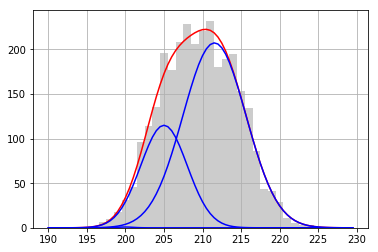

In [20]:
draw(params) ###variationalinference2draw

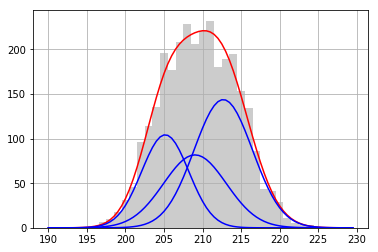

In [19]:
draw(params_history[100])

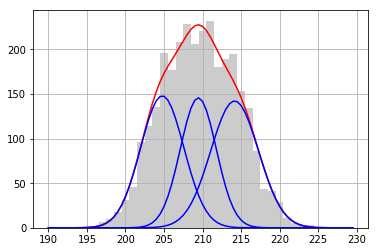

In [18]:
draw(params_history[10])

In [11]:
params_history

{10:            tau         zeta      mu_avg       alpha         beta     z_std
 0  1014.461925  1014.461925  204.776089  507.730963  4010.162075  2.810374
 1   868.359801   868.359801  209.451311  434.679900  2376.718035  2.338321
 2  1120.178274  1120.178274  214.164443  560.589137  5393.561668  3.101812,
 20:            tau         zeta      mu_avg       alpha         beta     z_std
 0   982.978341   982.978341  204.884171  491.989171  4254.275250  2.940594
 1   851.324100   851.324100  209.362310  426.162050  3217.770963  2.747832
 2  1168.697558  1168.697558  213.816753  584.848779  6445.689367  3.319807,
 30:            tau         zeta      mu_avg       alpha         beta     z_std
 0   954.640912   954.640912  204.946561  477.820456  4317.628823  3.006009
 1   844.419636   844.419636  209.295157  422.709818  3874.835892  3.027649
 2  1203.939452  1203.939452  213.578588  602.469726  7165.829423  3.448781,
 40:            tau         zeta      mu_avg       alpha         beta    

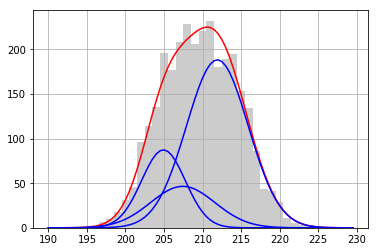

In [31]:
draw(params_history[500])